---
# 
---

In this notebook

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

### Define files

In [4]:
#data_dir = '../data/'
data_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\data\\'
model_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\'

#ghg = 'GreenHouse_Gases/processed/'
ghg = 'GreenHouse_Gases\\processed\\'

frequency = 'DLY'

climate_file = 'ECCC\\processed\\daily\\daily_processed.csv'
#climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population\\processed\\Montreal.csv'
#population_file = 'Population/processed/Montreal.csv'

co2_file = 'ch4_1850-2099_SSP2_45.csv'
ch4_file = 'co2_1850-2099_SSP2_45.csv'

scenario = 'SSP2-45'

### Define variables

**Daily**

In [7]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 
Tmean = 'Mean Temp (°C)'

cols = ['Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)',
       'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag']

**Monthly**

### Read data files

In [10]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df

CH4
Year                   
1850-01-01   791.600000
1851-01-01   792.859068
1852-01-01   794.156502
1853-01-01   795.493289
1854-01-01   796.859405
...                 ...
2095-01-01  1698.879883
2096-01-01  1695.429810
2097-01-01  1692.139893
2098-01-01  1689.009888
2099-01-01  1686.019897

[250 rows x 1 columns]

In [11]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df.drop(columns = 'Data Source', inplace=True)
ch4_df

CO2
Year                  
1850-01-01  285.200000
1851-01-01  285.100000
1852-01-01  285.000000
1853-01-01  285.000000
1854-01-01  284.900000
...                ...
2095-01-01  600.885986
2096-01-01  601.365967
2097-01-01  601.796997
2098-01-01  602.177002
2099-01-01  602.505005

[250 rows x 1 columns]

In [12]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

Population
1801-01-01  9.000000e+03
1802-01-01  9.389547e+03
1803-01-01  9.788026e+03
1804-01-01  1.019544e+04
1805-01-01  1.061293e+04
...                  ...
2095-01-01  2.258385e+06
2096-01-01  2.249969e+06
2097-01-01  2.240726e+06
2098-01-01  2.230707e+06
2099-01-01  2.219886e+06

[299 rows x 1 columns]

In [13]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


Station  Longitude (x)  Latitude (y)  \
Date/Time                                                             
1891-10-22  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-23  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-24  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-25  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-26  Montreal (McTavish/McGill)         -73.58          45.5   
...                                ...            ...           ...   
2025-03-23  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-24  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-25  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-26  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-27  Montreal (McTavish/McGill)         -73.58          45.5   

               Station Name Climate ID  Year  Month  Day  Data Quality  \
Date/Time                                                                
1891-10-22  MONTREAL MCGILL    7025280  1891     10   22           NaN   
1891-10-23  MONTREAL MCGILL    7025280  1891     10   23           NaN   
1891-10-24  MONTREAL MCGILL    7025280  1891     10   24           NaN   
1891-10-25  MONTREAL MCGILL    7025280  1891     10   25           NaN   
1891-10-26  MONTREAL MCGILL    7025280  1891     10   26           NaN   
...                     ...        ...   ...    ...  ...           ...   
2025-03-23         MCTAVISH    7024745  2025      3   23           NaN   
2025-03-24         MCTAVISH    7024745  2025      3   24           NaN   
2025-03-25         MCTAVISH    7024745  2025      3   25           NaN   
2025-03-26         MCTAVISH    7024745  2025      3   26           NaN   
2025-03-27         MCTAVISH    7024745  2025      3   27           NaN   

            Max Temp (°C)  ... Total Snow (cm)  Total Snow Flag  \
Date/Time                  ...                                    
1891-10-22            5.6  ...             0.0                T   
1891-10-23            3.9  ...             0.0              NaN   
1891-10-24            5.0  ...             0.0              NaN   
1891-10-25            3.3  ...             0.0              NaN   
1891-10-26           10.6  ...             0.0              NaN   
...                   ...  ...             ...              ...   
2025-03-23           -1.6  ...             NaN              NaN   
2025-03-24            3.9  ...             NaN              NaN   
2025-03-25            4.5  ...             NaN              NaN   
2025-03-26            4.8  ...             NaN              NaN   
2025-03-27            7.1  ...             NaN              NaN   

           Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
Date/Time                                                           
1891-10-22               0.0                  T               NaN   
1891-10-23               0.0                NaN               NaN   
1891-10-24               0.0                NaN               NaN   
1891-10-25               0.0                NaN               NaN   
1891-10-26               4.1                NaN               NaN   
...                      ...                ...               ...   
2025-03-23               0.0                NaN              10.0   
2025-03-24               6.7                NaN               9.0   
2025-03-25               1.1                NaN              11.0   
2025-03-26               0.4                NaN               4.0   
2025-03-27               0.5                NaN               1.0   

            Snow on Grnd Flag Dir of Max Gust (10s deg)  Dir of Max Gust Flag  \
Date/Time                                                                       
1891-10-22                NaN                       NaN                   NaN   
1891-10-23                NaN                       NaN                   NaN   
1891-10-24                NaN                     

In [14]:
wx_df['tmin_lag1'] = wx_df[Tmin].shift(1)
wx_df['tmax_lag1'] = wx_df[Tmax].shift(1)
wx_df

Station  Longitude (x)  Latitude (y)  \
Date/Time                                                             
1891-10-22  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-23  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-24  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-25  Montreal (McTavish/McGill)         -73.58          45.5   
1891-10-26  Montreal (McTavish/McGill)         -73.58          45.5   
...                                ...            ...           ...   
2025-03-23  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-24  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-25  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-26  Montreal (McTavish/McGill)         -73.58          45.5   
2025-03-27  Montreal (McTavish/McGill)         -73.58          45.5   

               Station Name Climate ID  Year  Month  Day  Data Quality  \
Date/Time                                                                
1891-10-22  MONTREAL MCGILL    7025280  1891     10   22           NaN   
1891-10-23  MONTREAL MCGILL    7025280  1891     10   23           NaN   
1891-10-24  MONTREAL MCGILL    7025280  1891     10   24           NaN   
1891-10-25  MONTREAL MCGILL    7025280  1891     10   25           NaN   
1891-10-26  MONTREAL MCGILL    7025280  1891     10   26           NaN   
...                     ...        ...   ...    ...  ...           ...   
2025-03-23         MCTAVISH    7024745  2025      3   23           NaN   
2025-03-24         MCTAVISH    7024745  2025      3   24           NaN   
2025-03-25         MCTAVISH    7024745  2025      3   25           NaN   
2025-03-26         MCTAVISH    7024745  2025      3   26           NaN   
2025-03-27         MCTAVISH    7024745  2025      3   27           NaN   

            Max Temp (°C)  ... Total Precip (mm)  Total Precip Flag  \
Date/Time                  ...                                        
1891-10-22            5.6  ...               0.0                  T   
1891-10-23            3.9  ...               0.0                NaN   
1891-10-24            5.0  ...               0.0                NaN   
1891-10-25            3.3  ...               0.0                NaN   
1891-10-26           10.6  ...               4.1                NaN   
...                   ...  ...               ...                ...   
2025-03-23           -1.6  ...               0.0                NaN   
2025-03-24            3.9  ...               6.7                NaN   
2025-03-25            4.5  ...               1.1                NaN   
2025-03-26            4.8  ...               0.4                NaN   
2025-03-27            7.1  ...               0.5                NaN   

           Snow on Grnd (cm)  Snow on Grnd Flag Dir of Max Gust (10s deg)  \
Date/Time                                                                   
1891-10-22               NaN                NaN                       NaN   
1891-10-23               NaN                NaN                       NaN   
1891-10-24               NaN                NaN                       NaN   
1891-10-25               NaN                NaN                       NaN   
1891-10-26               NaN                NaN                       NaN   
...                      ...                ...                       ...   
2025-03-23              10.0                NaN                       NaN   
2025-03-24               9.0                NaN                       NaN   
2025-03-25              11.0                NaN                       NaN   
2025-03-26               4.0                NaN                       NaN   
2025-03-27               1.0                NaN                       NaN   

            Dir of Max Gust Flag Spd of Max Gust (km/h)  Spd of Max Gust Flag  \
Date/Time                                                                       
1891-10-22                   NaN                    NaN 

### Remove incomplete start and end year of climate dataset

In [16]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

Station  Longitude (x)  Latitude (y)  Station Name  Climate ID  Month  \
Year                                                                          
1891       71             71            71            71          71     71   
2025       86             86            86            86          86     86   

      Day  Data Quality  Max Temp (°C)  Max Temp Flag  ...  Total Precip (mm)  \
Year                                                   ...                      
1891   71             0             71              0  ...                 71   
2025   86             0             86              0  ...                 85   

      Total Precip Flag  Snow on Grnd (cm)  Snow on Grnd Flag  \
Year                                                            
1891                 10                  0                  0   
2025                  1                 86                  0   

      Dir of Max Gust (10s deg)  Dir of Max Gust Flag  Spd of Max Gust (km/h)  \
Year                                                                            
1891                          0                     0                       0   
2025                         27                     0                      27   

      Spd of Max Gust Flag  tmin_lag1  tmax_lag1  
Year                                              
1891                     0         70         70  
2025                     0         86         86  

[2 rows x 32 columns]

In [17]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()
print(type(start_wx), end_wx)

for year in [start_wx, end_wx] :

    nbr_days_year = 366 if pd.Period(year, freq='Y').is_leap_year else 365

    yr = int(year.strftime('%Y'))
    nbr_obs_year = tmp[tmp.index == yr]['Station'].values[0]

    print('*',yr, nbr_obs_year, '*')
    
    if nbr_obs_year != nbr_days_year :
        print(f'Not full year. Removing partial {yr} from dataframe')
        wx_df = wx_df[wx_df['Year'] != yr]

        start_wx = wx_df.index.min()
        end_wx = wx_df.index.max()
    else :
        print(f'Full year. Not removing {yr} from obs dataframe.')
    
wx_df

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2025-03-27 00:00:00
* 1891 71 *
Not full year. Removing partial 1891 from dataframe
* 2025 86 *
Not full year. Removing partial 2025 from dataframe


Station  Longitude (x)  Latitude (y)  \
Date/Time                                                             
1892-01-01  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-02  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-03  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-04  Montreal (McTavish/McGill)         -73.58          45.5   
1892-01-05  Montreal (McTavish/McGill)         -73.58          45.5   
...                                ...            ...           ...   
2024-12-27  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-28  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-29  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-30  Montreal (McTavish/McGill)         -73.58          45.5   
2024-12-31  Montreal (McTavish/McGill)         -73.58          45.5   

               Station Name Climate ID  Year  Month  Day  Data Quality  \
Date/Time                                                                
1892-01-01  MONTREAL MCGILL    7025280  1892      1    1           NaN   
1892-01-02  MONTREAL MCGILL    7025280  1892      1    2           NaN   
1892-01-03  MONTREAL MCGILL    7025280  1892      1    3           NaN   
1892-01-04  MONTREAL MCGILL    7025280  1892      1    4           NaN   
1892-01-05  MONTREAL MCGILL    7025280  1892      1    5           NaN   
...                     ...        ...   ...    ...  ...           ...   
2024-12-27         MCTAVISH    7024745  2024     12   27           NaN   
2024-12-28         MCTAVISH    7024745  2024     12   28           NaN   
2024-12-29         MCTAVISH    7024745  2024     12   29           NaN   
2024-12-30         MCTAVISH    7024745  2024     12   30           NaN   
2024-12-31         MCTAVISH    7024745  2024     12   31           NaN   

            Max Temp (°C)  ... Total Precip (mm)  Total Precip Flag  \
Date/Time                  ...                                        
1892-01-01           -5.6  ...               0.0                  T   
1892-01-02            6.7  ...              11.2                NaN   
1892-01-03            2.2  ...              11.4                NaN   
1892-01-04           -7.2  ...               0.3                NaN   
1892-01-05          -12.2  ...               0.5                NaN   
...                   ...  ...               ...                ...   
2024-12-27           -6.1  ...               0.0                NaN   
2024-12-28           -1.7  ...               0.2                NaN   
2024-12-29            7.6  ...               5.2                NaN   
2024-12-30           10.6  ...              10.3                NaN   
2024-12-31            6.3  ...               0.0                NaN   

           Snow on Grnd (cm)  Snow on Grnd Flag Dir of Max Gust (10s deg)  \
Date/Time                                                                   
1892-01-01               NaN                NaN                       NaN   
1892-01-02               NaN                NaN                       NaN   
1892-01-03               NaN                NaN                       NaN   
1892-01-04               NaN                NaN                       NaN   
1892-01-05               NaN                NaN                       NaN   
...                      ...                ...                       ...   
2024-12-27              11.0                NaN                       NaN   
2024-12-28              11.0                NaN                       NaN   
2024-12-29              11.0                NaN                       NaN   
2024-12-30               5.0                NaN                      20.0   
2024-12-31               1.0                NaN                       NaN   

            Dir of Max Gust Flag Spd of Max Gust (km/h)  Spd of Max Gust Flag  \
Date/Time                                                                       
1892-01-01                   NaN                    NaN 

### Plot the data

In [19]:
stn = wx_df['Station'].unique()[0]
stn

'Montreal (McTavish/McGill)'

C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\1294534305.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


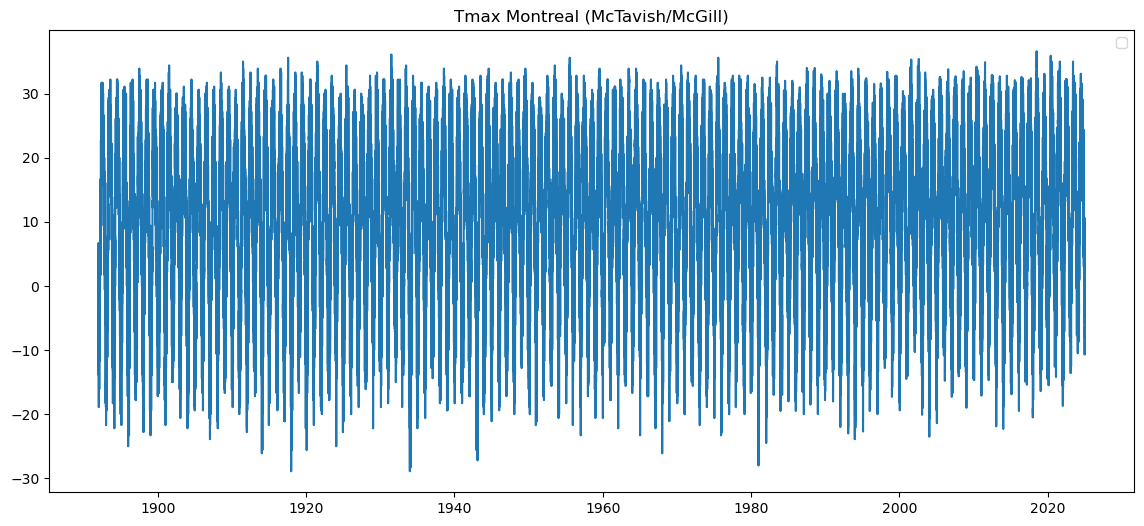

In [20]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmax])

plt.title(f'Tmax {stn}')

plt.legend()

plt.show()

C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\634575607.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


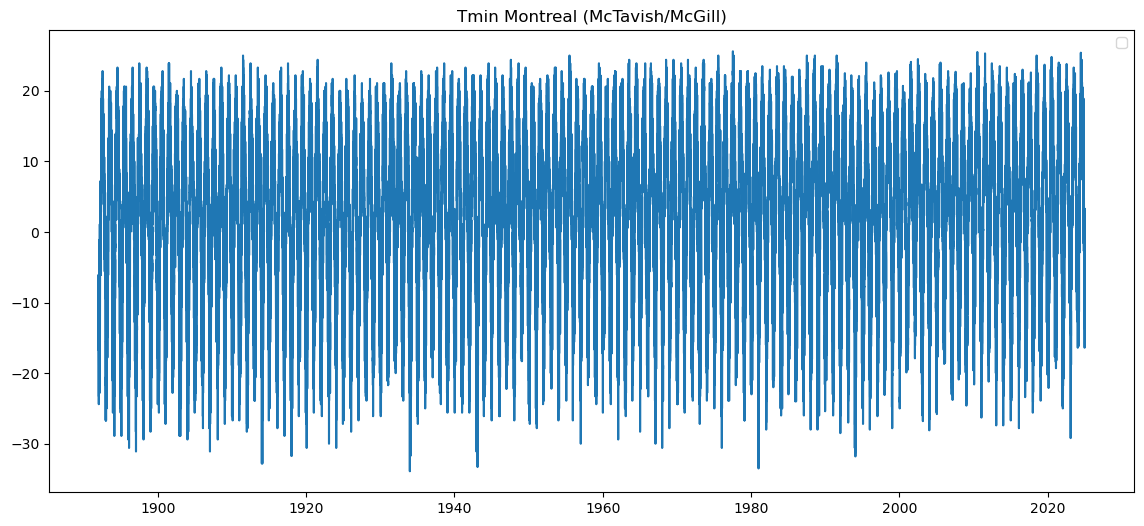

In [21]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmin])

plt.title(f'Tmin {stn}')

plt.legend()

plt.show()

C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\1541288815.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


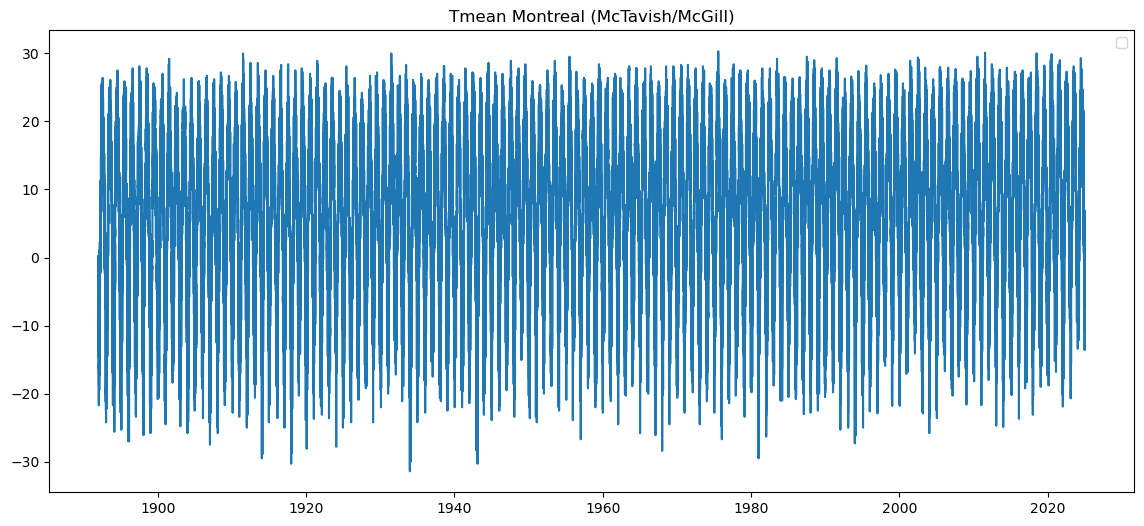

In [22]:
fig = plt.figure(figsize=(14,6))

ax = plt.plot(wx_df.index, wx_df[Tmean])

plt.title(f'Tmean {stn}')

plt.legend()

plt.show()

### Plot temperature trend by months

C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\897467635.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


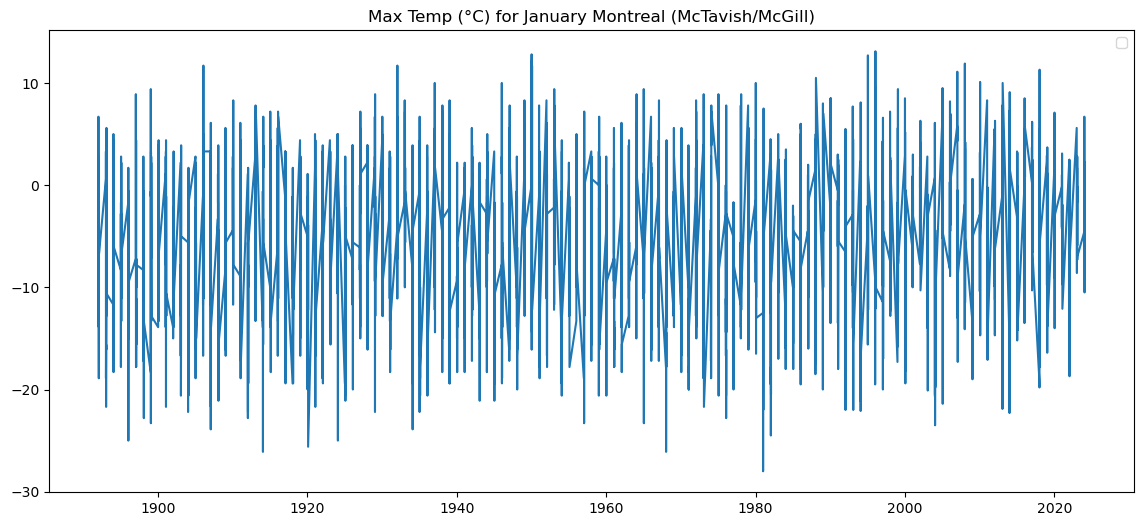

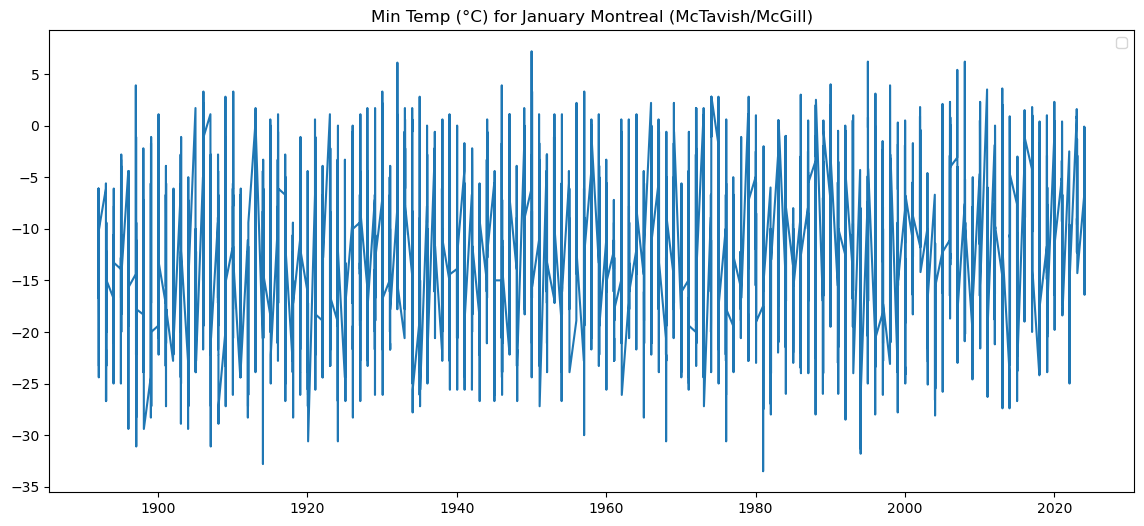

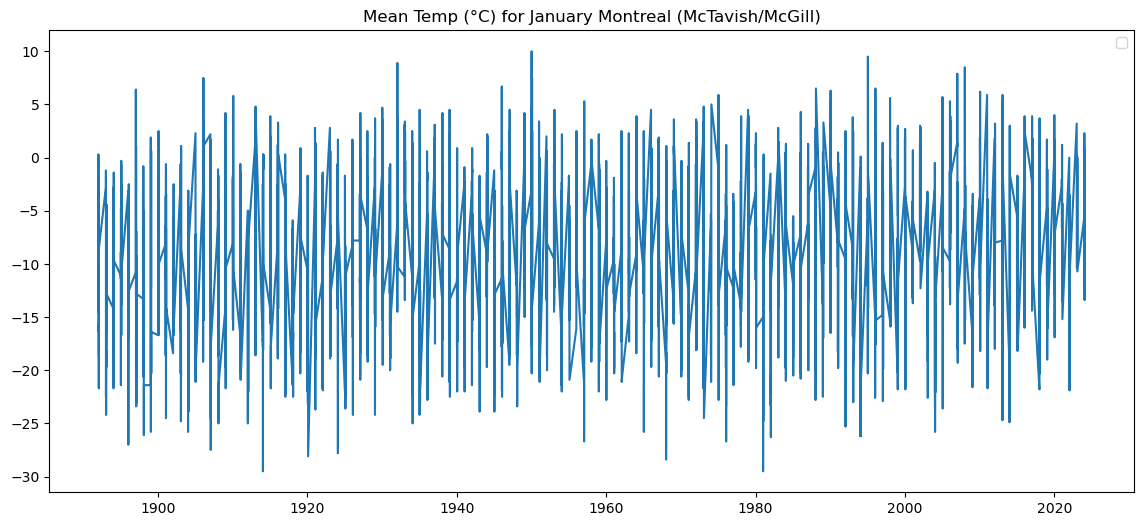

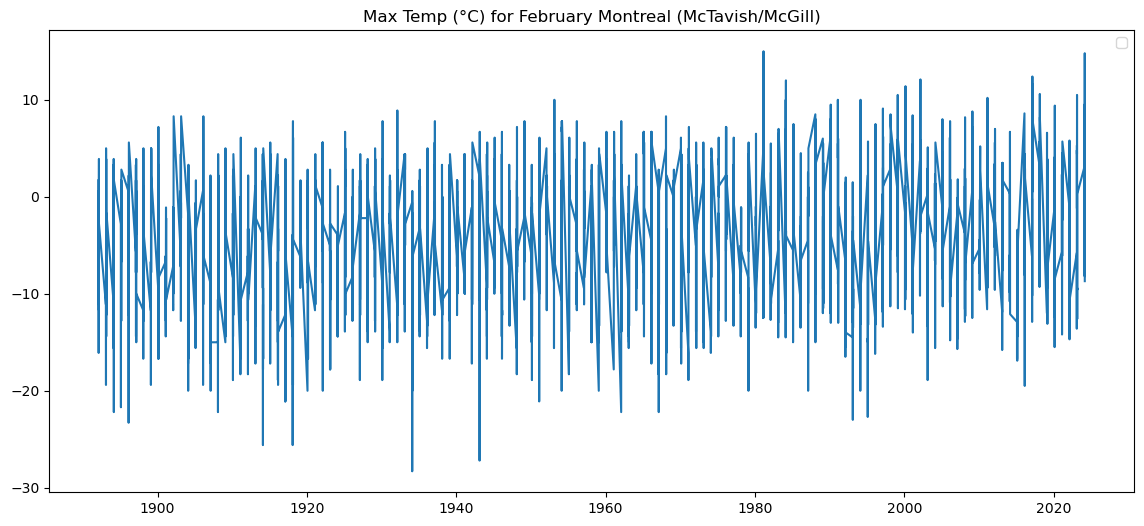

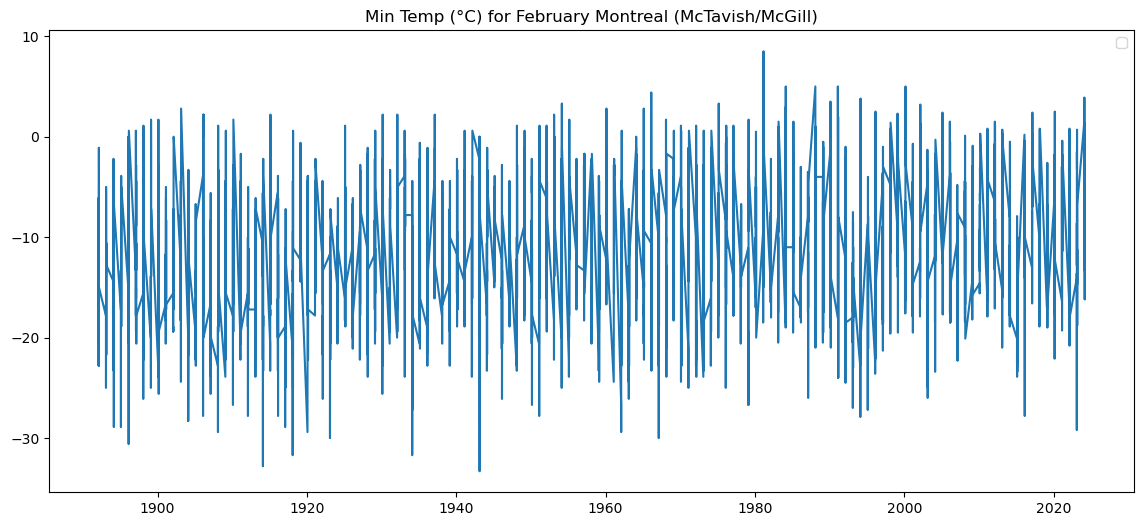

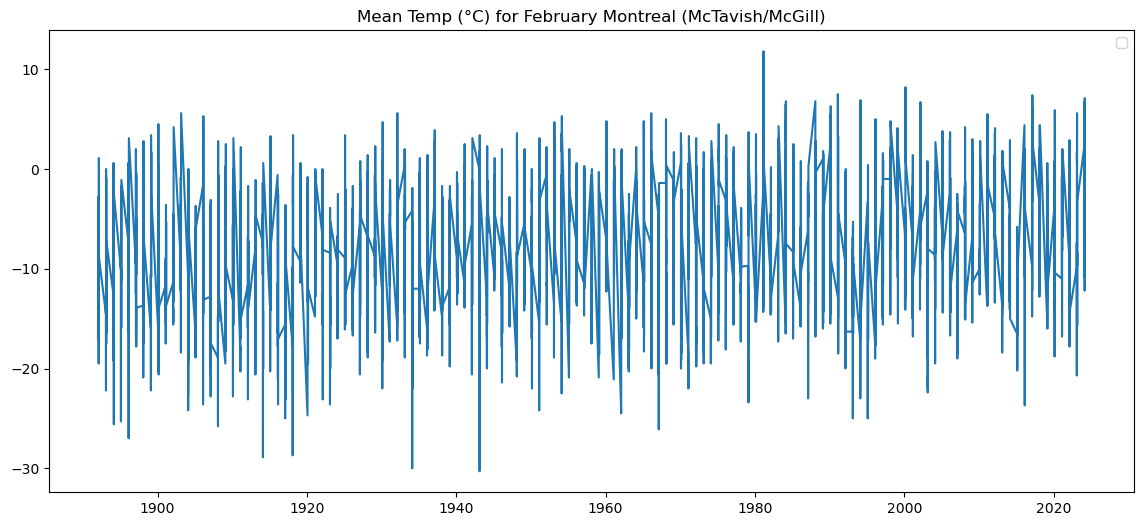

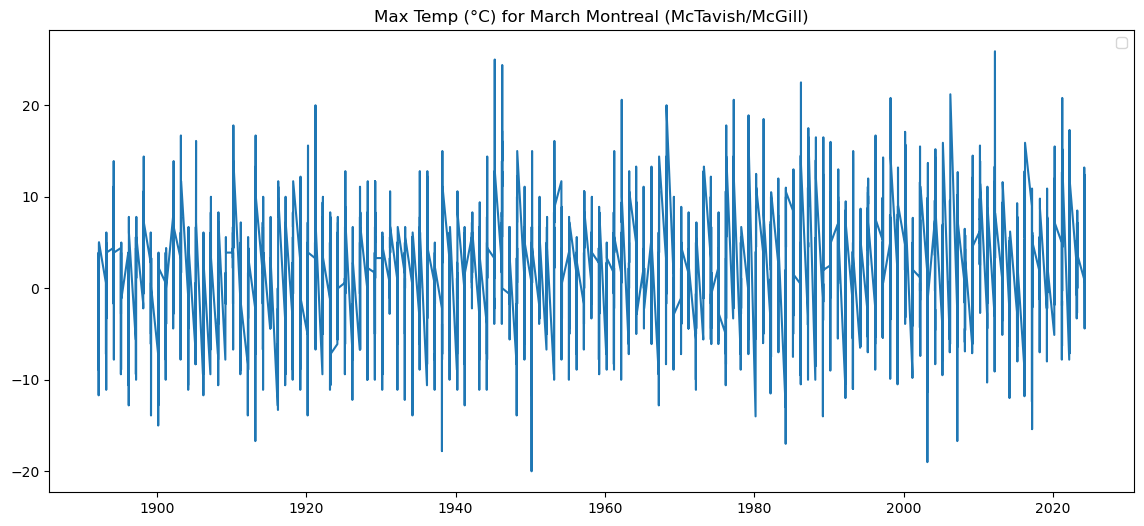

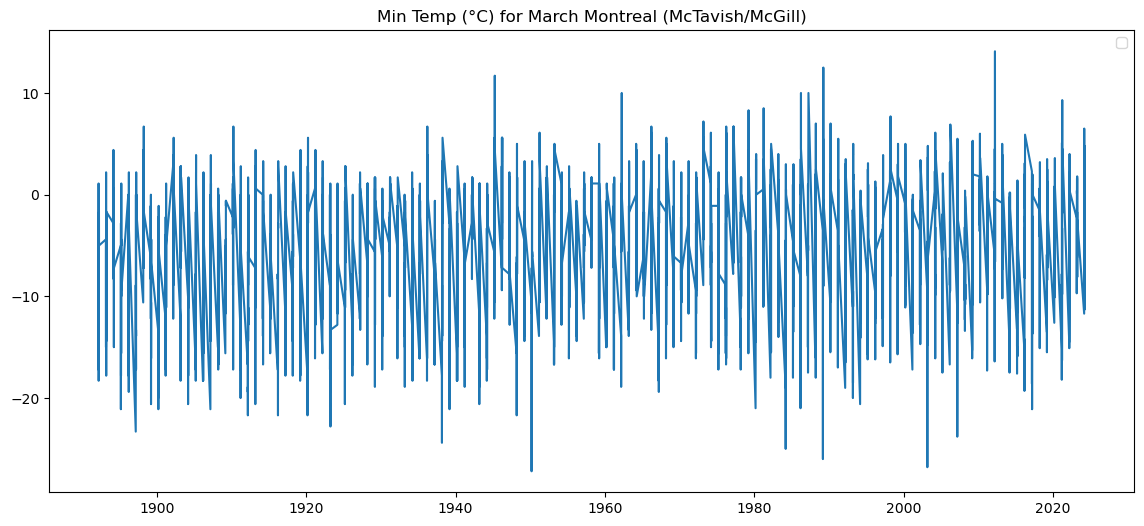

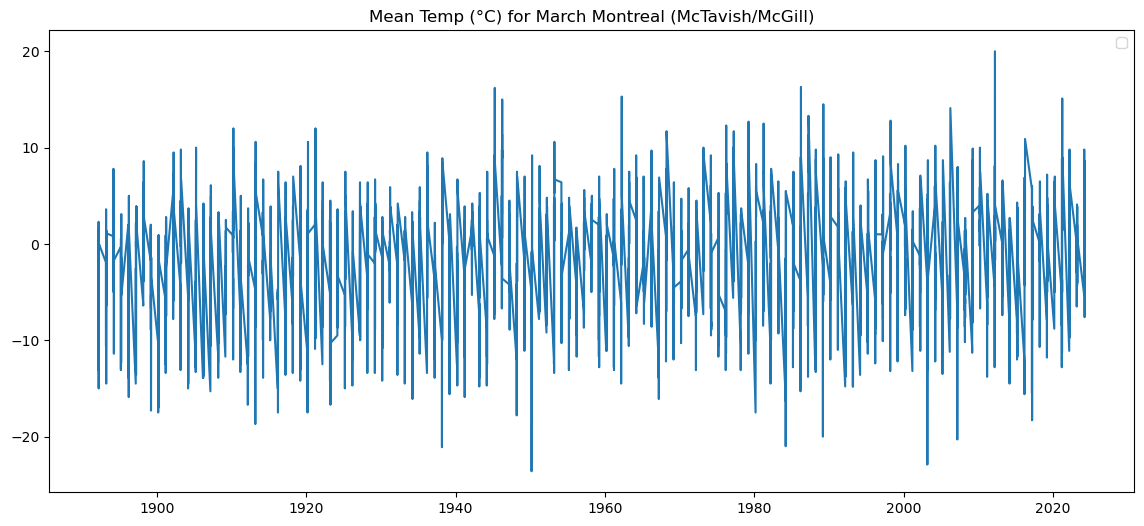

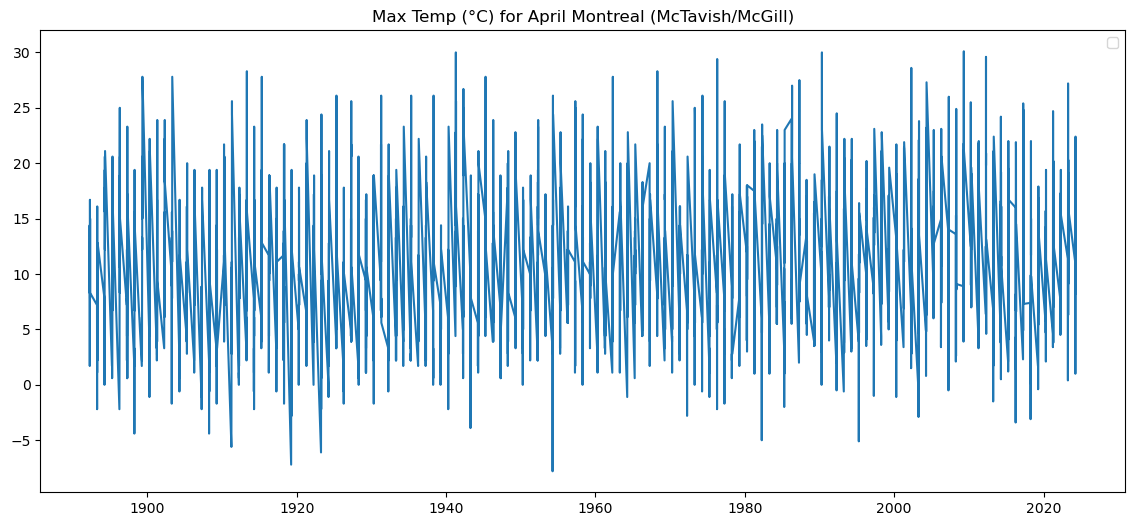

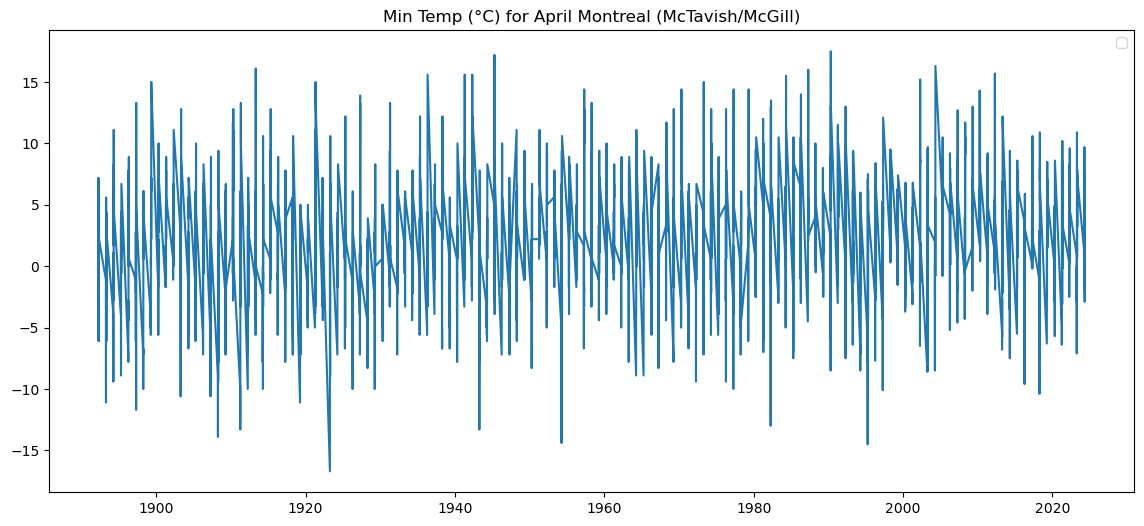

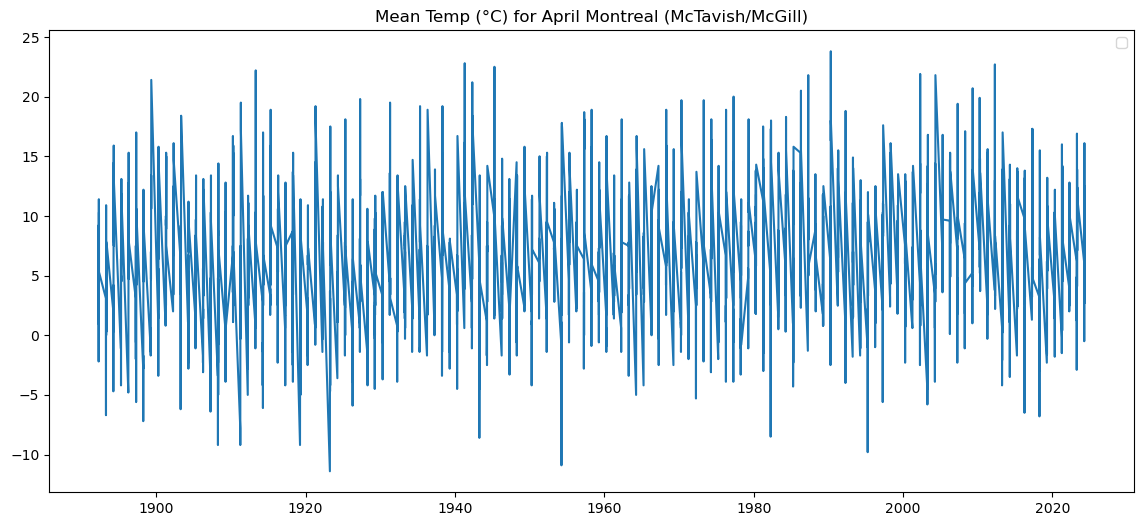

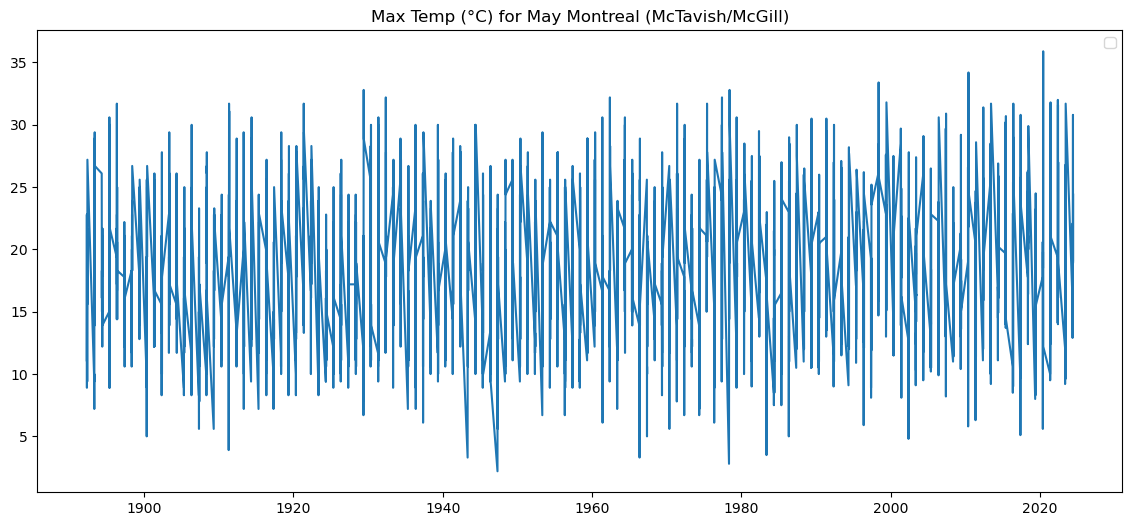

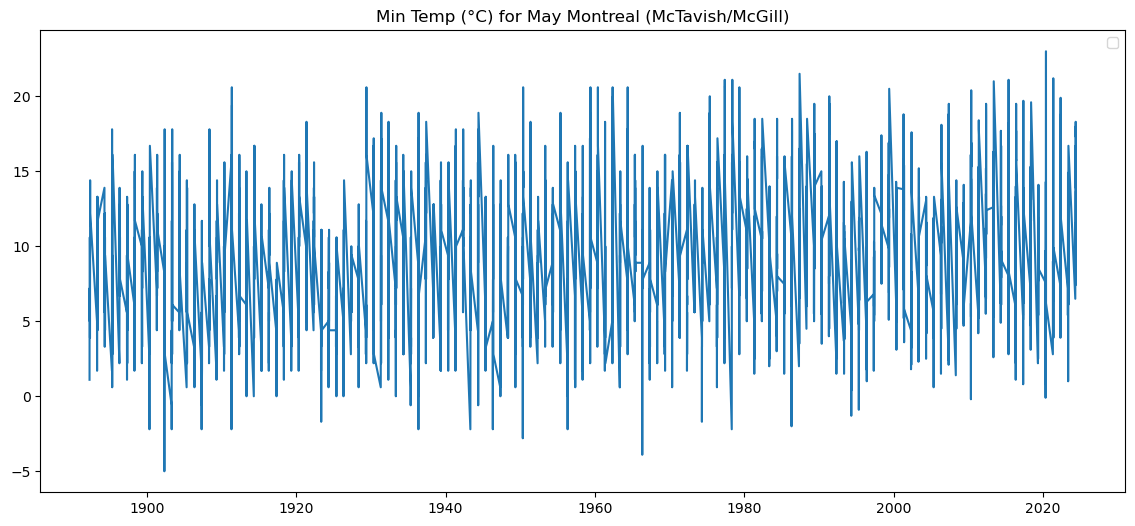

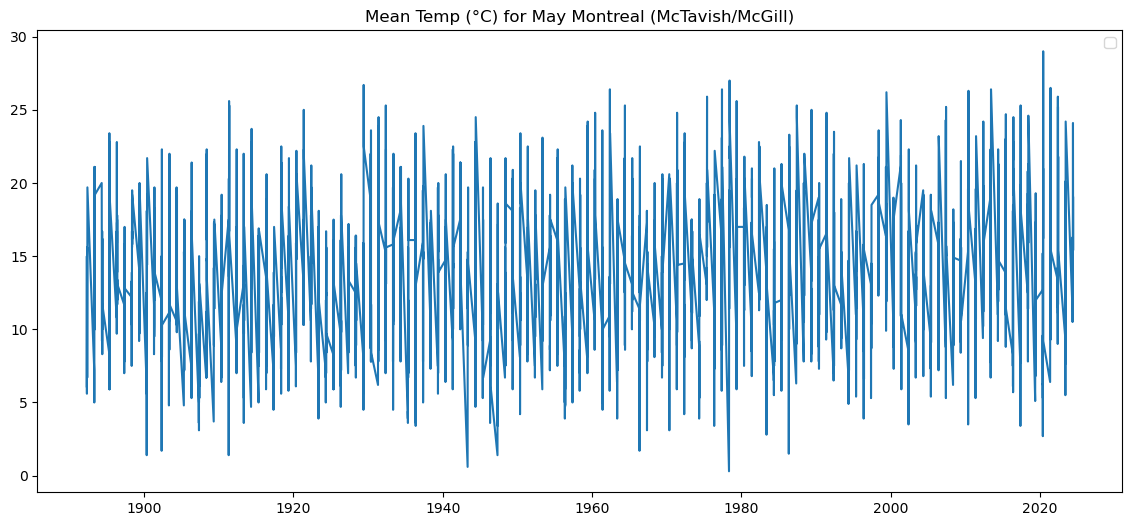

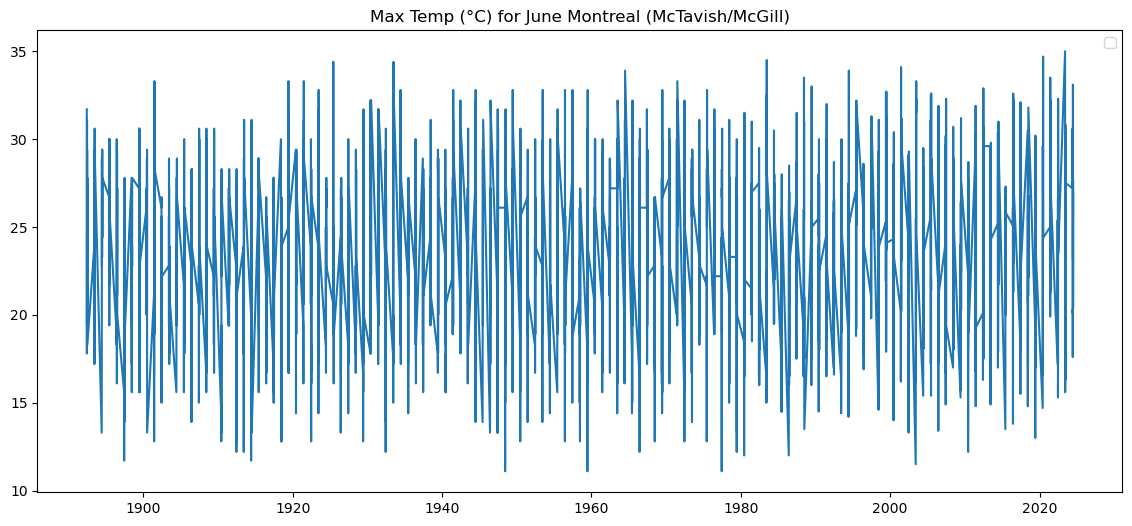

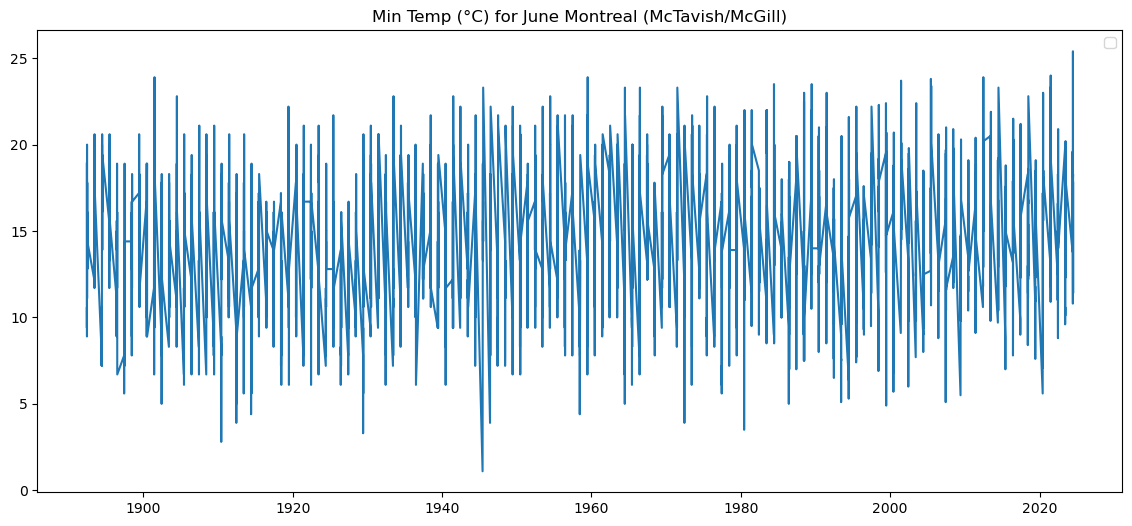

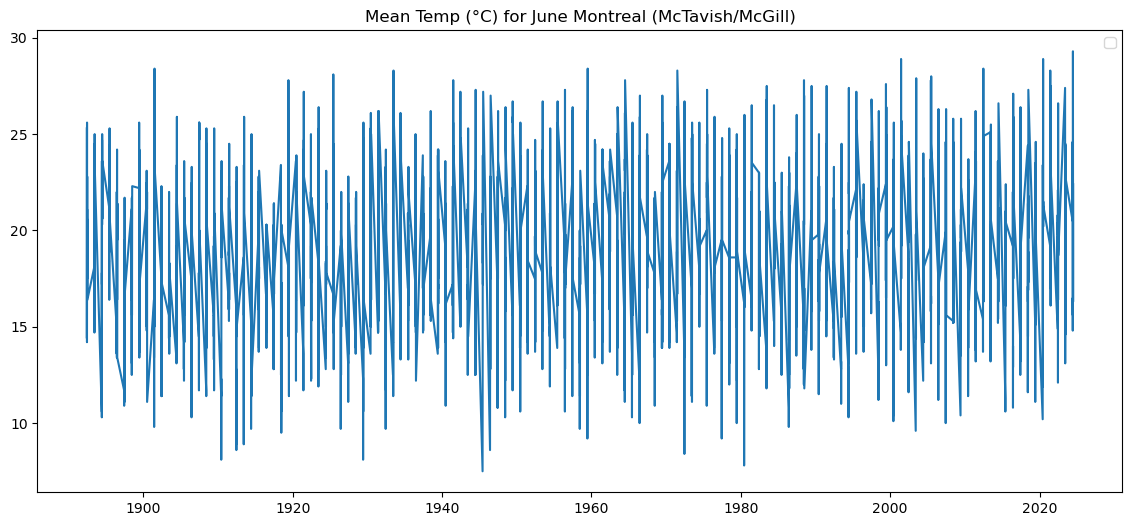

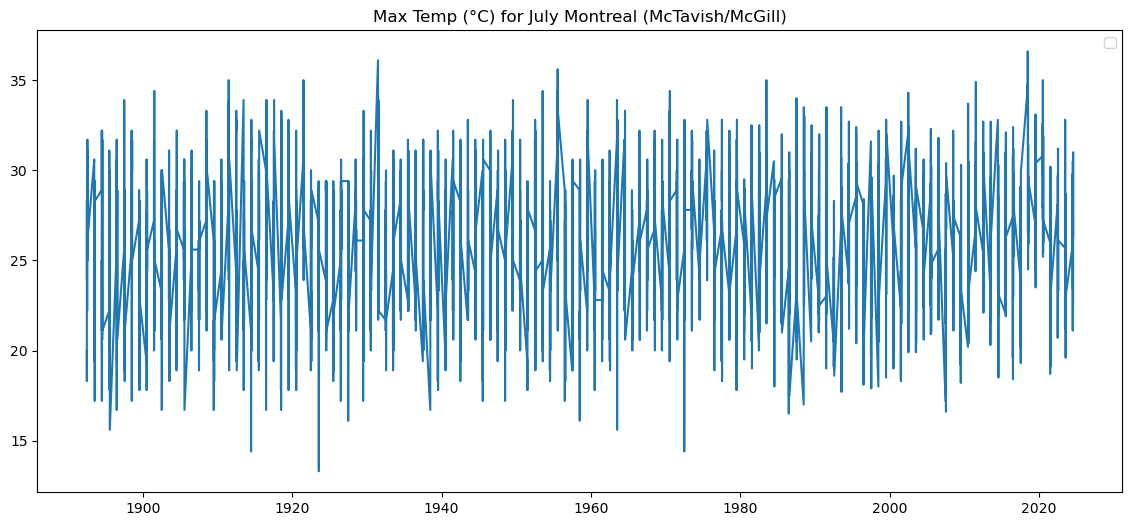

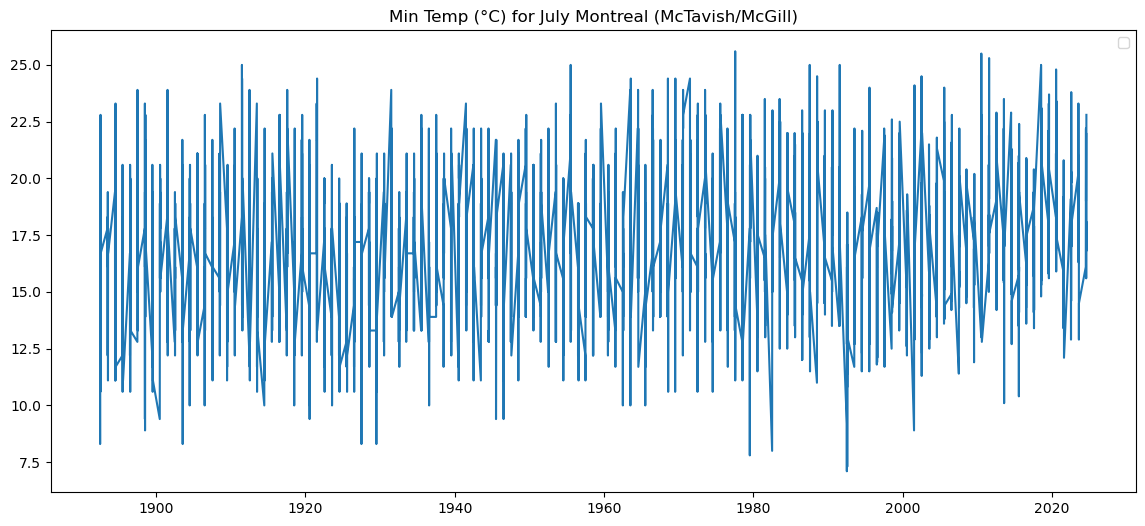

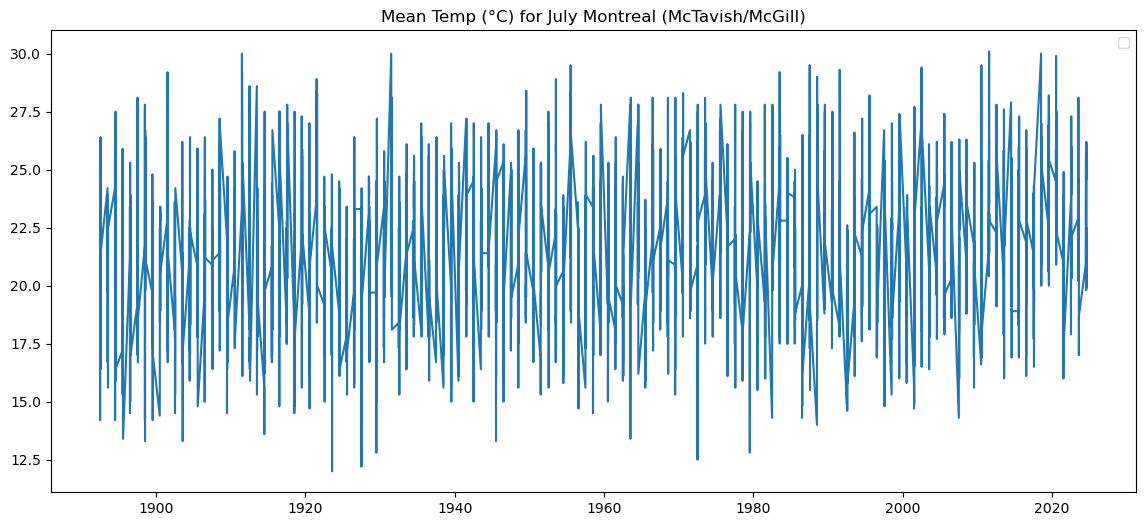

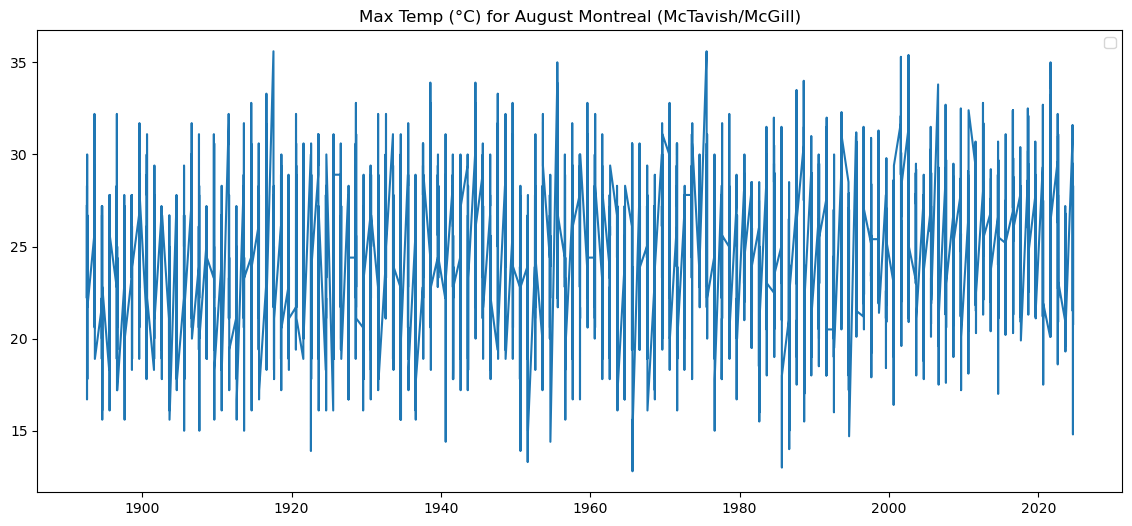

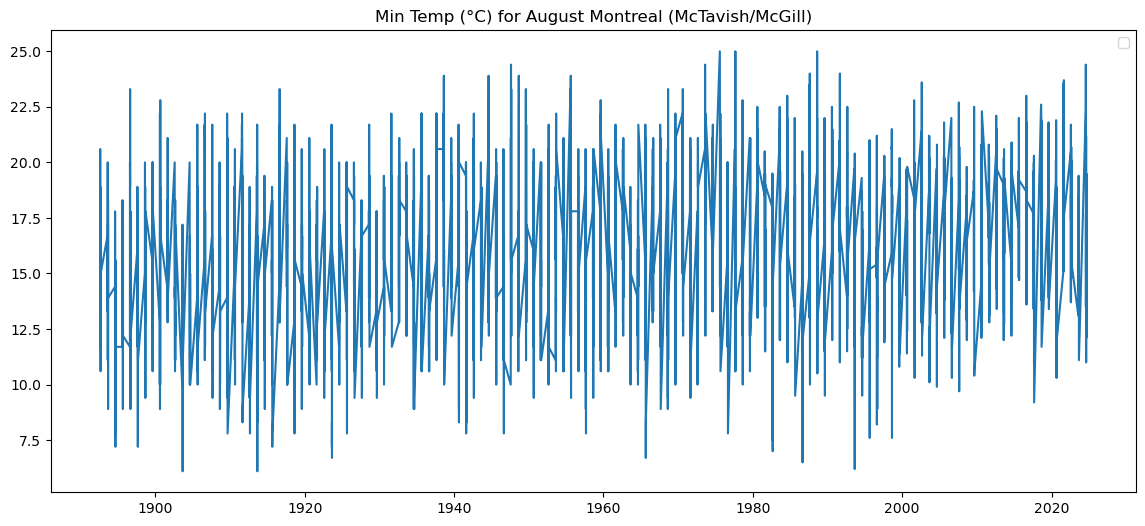

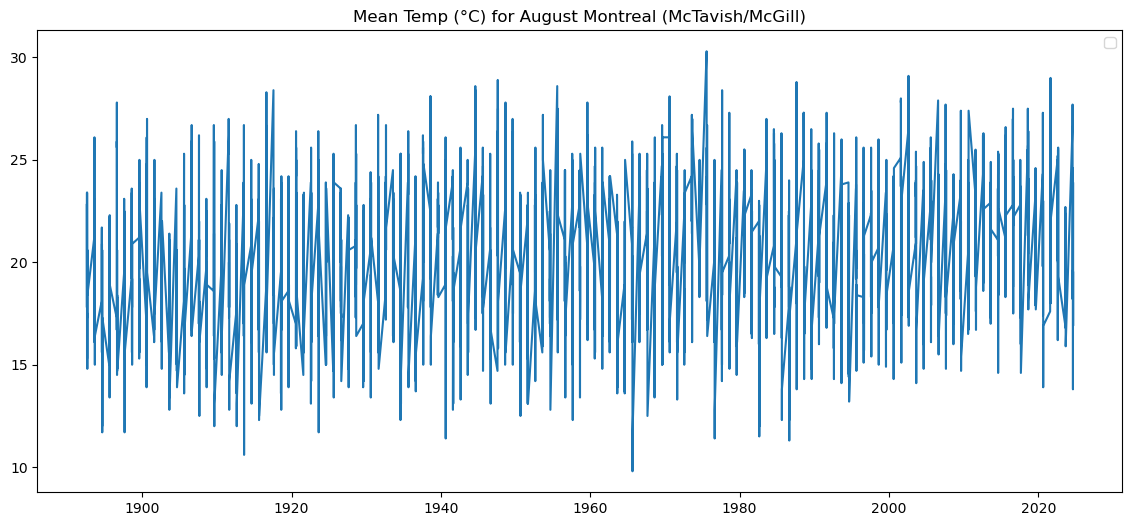

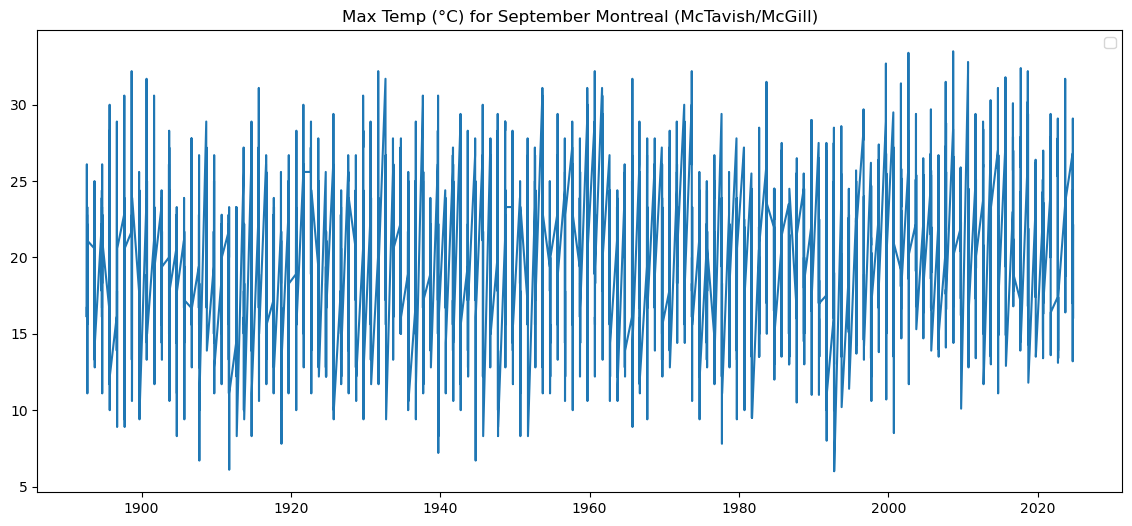

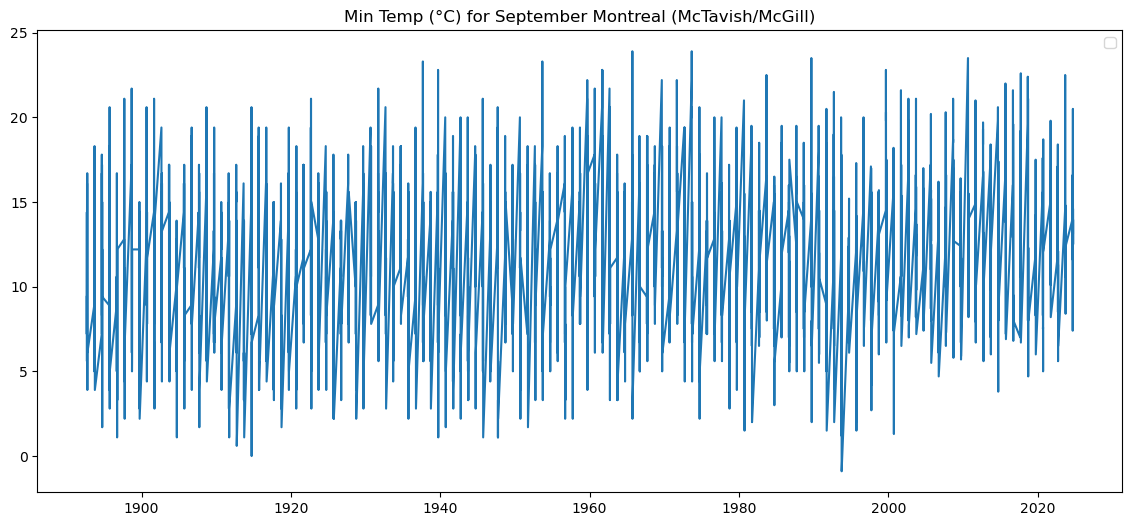

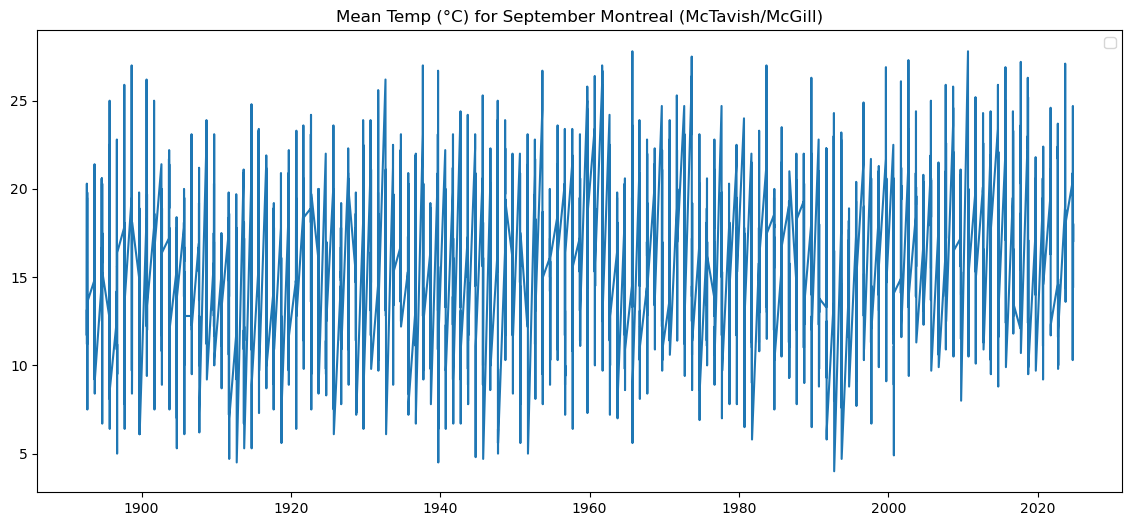

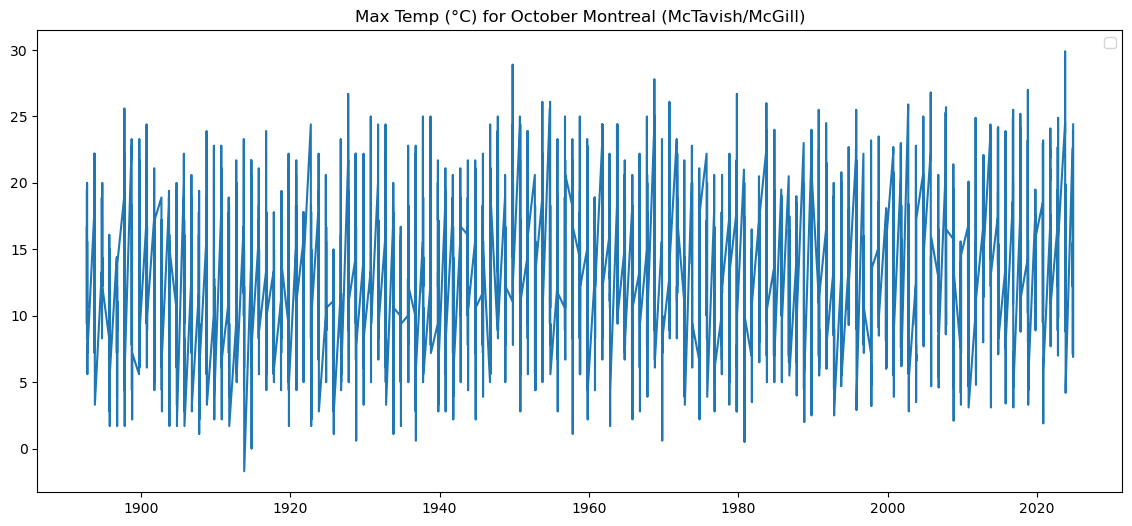

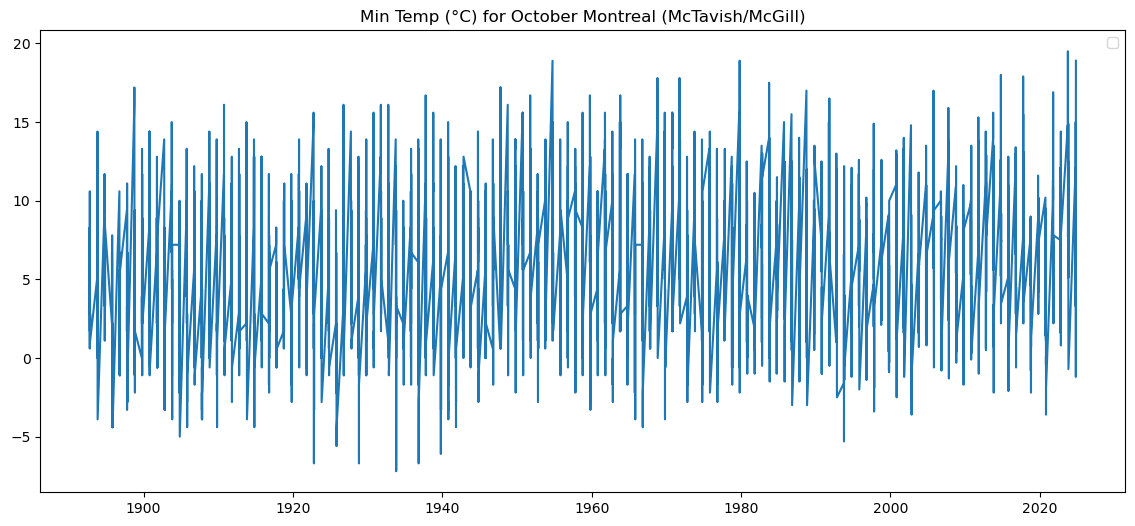

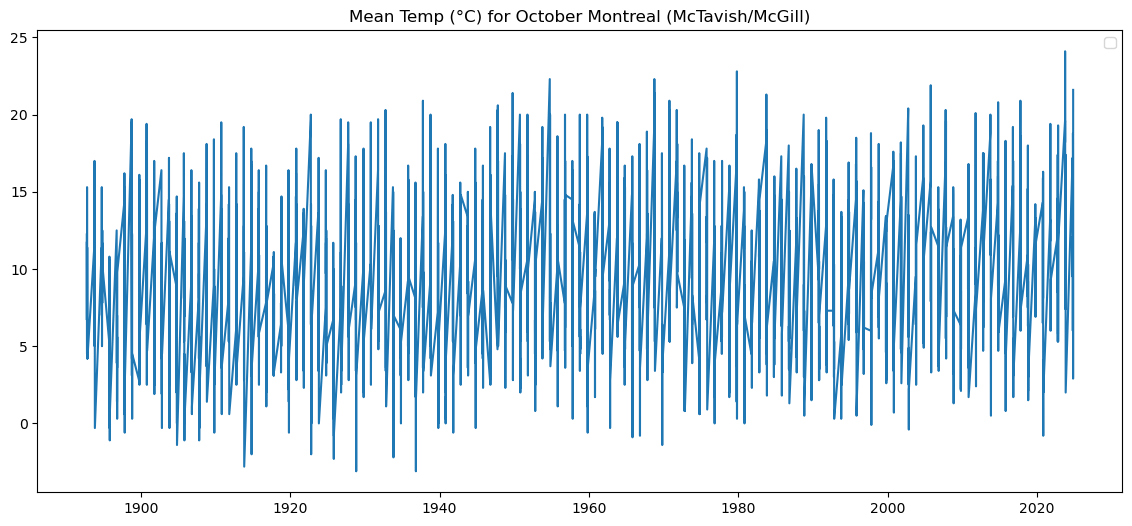

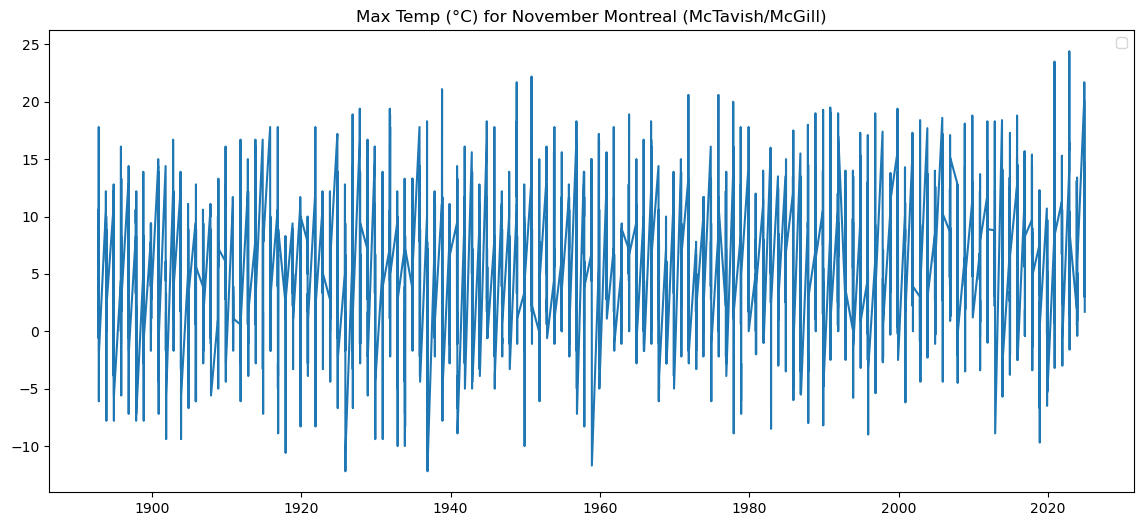

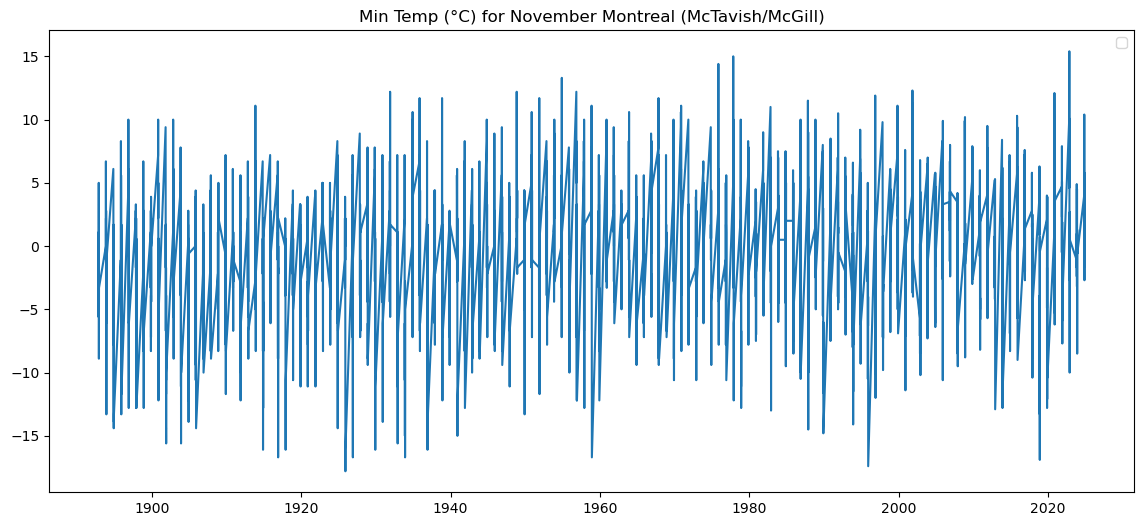

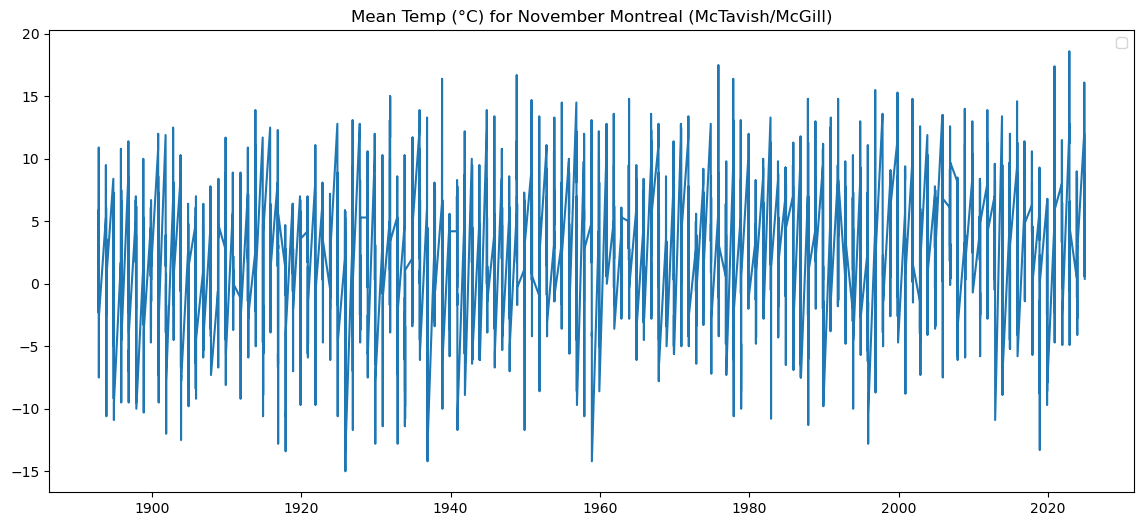

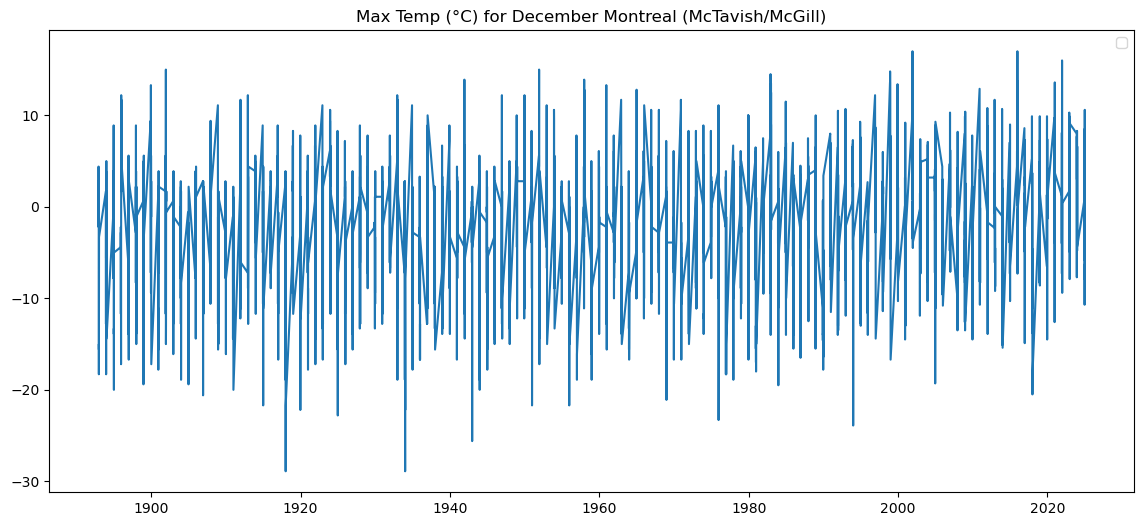

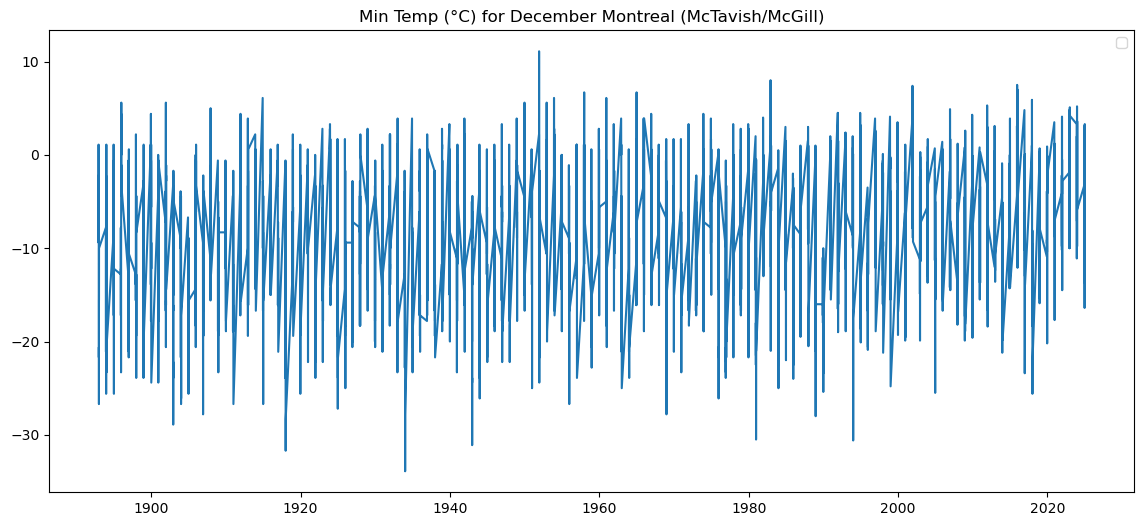

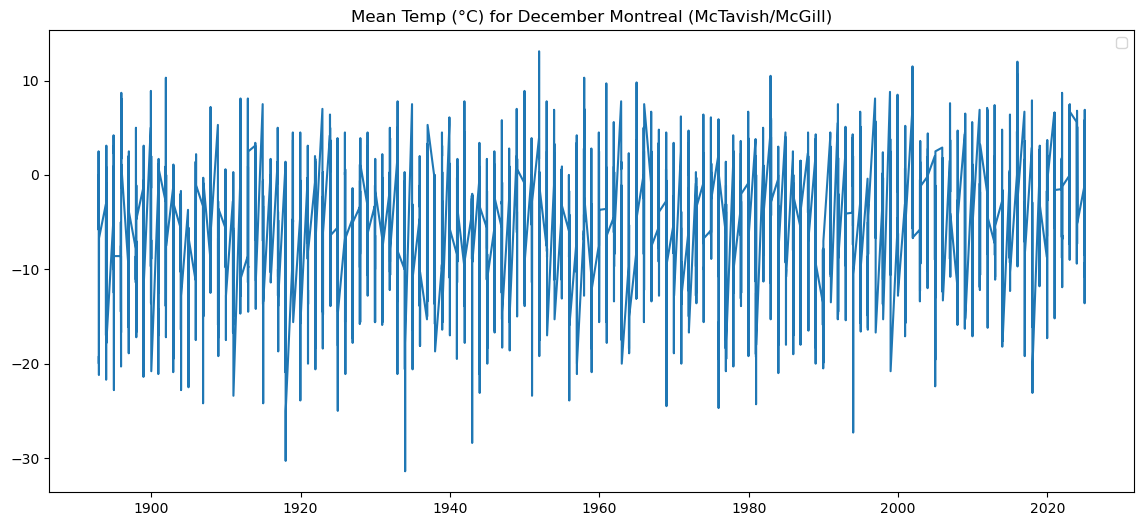

In [24]:
for month in range(1,13):

    month_str = pd.to_datetime(month, format='%m').strftime('%B')

    for T in [Tmax, Tmin, Tmean]:

        tmp = wx_df[wx_df['Month'] == month][T]

        fig = plt.figure(figsize=(14,6))

        ax = plt.plot(tmp.index, tmp)

        plt.title(f'{T} for {month_str} {stn}')

        plt.legend()

        plt.show()

### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [26]:
if frequency == 'DLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="D")
    print(new_range)
    
    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('D').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('D').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('D').interpolate()
    
elif frequency == 'MLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="ME")
    print(new_range)

    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('ME').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('ME').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('ME').interpolate()
else :
    print('Frequency is NOT monthly or daily')

DatetimeIndex(['1892-01-01', '1892-01-02', '1892-01-03', '1892-01-04',
               '1892-01-05', '1892-01-06', '1892-01-07', '1892-01-08',
               '1892-01-09', '1892-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=48578, freq='D')


In [27]:
co2_df

CH4
1892-01-01   859.921329
1892-01-02   859.925885
1892-01-03   859.930442
1892-01-04   859.934998
1892-01-05   859.939554
...                 ...
2024-12-27  1934.802141
2024-12-28  1934.802141
2024-12-29  1934.802141
2024-12-30  1934.802141
2024-12-31  1934.802141

[48578 rows x 1 columns]

In [28]:
ch4_df

CO2
1892-01-01  294.800000
1892-01-02  294.799727
1892-01-03  294.799454
1892-01-04  294.799180
1892-01-05  294.798907
...                ...
2024-12-27  424.610000
2024-12-28  424.610000
2024-12-29  424.610000
2024-12-30  424.610000
2024-12-31  424.610000

[48578 rows x 1 columns]

In [29]:
pop_df

Population
1892-01-01  2.609199e+05
1892-01-02  2.609370e+05
1892-01-03  2.609540e+05
1892-01-04  2.609711e+05
1892-01-05  2.609881e+05
...                  ...
2024-12-27  2.200807e+06
2024-12-28  2.200807e+06
2024-12-29  2.200807e+06
2024-12-30  2.200807e+06
2024-12-31  2.200807e+06

[48578 rows x 1 columns]

### Put all the data into a single dataframe

In [31]:
full_df = pd.concat([co2_df, ch4_df, pop_df, wx_df[[Tmax,Tmin]]], axis=1)
full_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2024-12-27  1934.802141  424.610000  2.200807e+06           -6.1   
2024-12-28  1934.802141  424.610000  2.200807e+06           -1.7   
2024-12-29  1934.802141  424.610000  2.200807e+06            7.6   
2024-12-30  1934.802141  424.610000  2.200807e+06           10.6   
2024-12-31  1934.802141  424.610000  2.200807e+06            6.3   

            Min Temp (°C)  
1892-01-01          -11.7  
1892-01-02           -6.1  
1892-01-03           -7.8  
1892-01-04          -15.0  
1892-01-05          -16.7  
...                   ...  
2024-12-27          -13.2  
2024-12-28           -9.6  
2024-12-29           -2.6  
2024-12-30            3.3  
2024-12-31            1.6  

[48578 rows x 5 columns]

In [32]:
# Add lagged temperature features
full_df['tmin_lag1'] = wx_df['tmin_lag1']
full_df['tmax_lag1'] = wx_df['tmax_lag1']
full_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2024-12-27  1934.802141  424.610000  2.200807e+06           -6.1   
2024-12-28  1934.802141  424.610000  2.200807e+06           -1.7   
2024-12-29  1934.802141  424.610000  2.200807e+06            7.6   
2024-12-30  1934.802141  424.610000  2.200807e+06           10.6   
2024-12-31  1934.802141  424.610000  2.200807e+06            6.3   

            Min Temp (°C)  tmin_lag1  tmax_lag1  
1892-01-01          -11.7      -18.3      -10.6  
1892-01-02           -6.1      -11.7       -5.6  
1892-01-03           -7.8       -6.1        6.7  
1892-01-04          -15.0       -7.8        2.2  
1892-01-05          -16.7      -15.0       -7.2  
...                   ...        ...        ...  
2024-12-27          -13.2      -13.7       -7.9  
2024-12-28           -9.6      -13.2       -6.1  
2024-12-29           -2.6       -9.6       -1.7  
2024-12-30            3.3       -2.6        7.6  
2024-12-31            1.6        3.3       10.6  

[48578 rows x 7 columns]

In [133]:
full_df['dayofyear'] = full_df.index.dayofyear
full_df['sin_doy'] = np.sin(2 * np.pi * full_df['dayofyear'] / 365.)
full_df['cos_doy'] = np.cos(2 * np.pi * full_df['dayofyear'] / 365.)
full_df.drop(columns=['dayofyear'], inplace=True)
full_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2024-12-27  1934.802141  424.610000  2.200807e+06           -6.1   
2024-12-28  1934.802141  424.610000  2.200807e+06           -1.7   
2024-12-29  1934.802141  424.610000  2.200807e+06            7.6   
2024-12-30  1934.802141  424.610000  2.200807e+06           10.6   
2024-12-31  1934.802141  424.610000  2.200807e+06            6.3   

            Min Temp (°C)  tmin_lag1  tmax_lag1       sin_doy   cos_doy  
1892-01-01          -11.7      -18.3      -10.6  1.721336e-02  0.999852  
1892-01-02           -6.1      -11.7       -5.6  3.442161e-02  0.999407  
1892-01-03           -7.8       -6.1        6.7  5.161967e-02  0.998667  
1892-01-04          -15.0       -7.8        2.2  6.880243e-02  0.997630  
1892-01-05          -16.7      -15.0       -7.2  8.596480e-02  0.996298  
...                   ...        ...        ...           ...       ...  
2024-12-27          -13.2      -13.7       -7.9 -5.161967e-02  0.998667  
2024-12-28           -9.6      -13.2       -6.1 -3.442161e-02  0.999407  
2024-12-29           -2.6       -9.6       -1.7 -1.721336e-02  0.999852  
2024-12-30            3.3       -2.6        7.6  6.432491e-16  1.000000  
2024-12-31            1.6        3.3       10.6  1.721336e-02  0.999852  

[48578 rows x 9 columns]

### Separate Train/Test/Validate dataset

In [135]:
cut_year_test = 2021
cut_year_val = 2023

cut_test = pd.to_datetime(cut_year_test, format='%Y')
cut_val = pd.to_datetime(cut_year_val, format='%Y')

train_df = full_df[full_df.index < cut_test]
test_df = full_df[(full_df.index >= cut_test) & (full_df.index < cut_val)]
val_df = full_df[full_df.index >= cut_val]

In [137]:
test_df

CH4         CO2    Population  Max Temp (°C)  \
2021-01-01  1894.800000  416.410000  1.762949e+06           -0.2   
2021-01-02  1894.844164  416.415808  1.763361e+06           -0.6   
2021-01-03  1894.888329  416.421616  1.763773e+06           -0.6   
2021-01-04  1894.932493  416.427425  1.764185e+06           -1.1   
2021-01-05  1894.976658  416.433233  1.764598e+06           -2.5   
...                 ...         ...           ...            ...   
2022-12-27  1921.552329  421.045068  2.100692e+06           -4.2   
2022-12-28  1921.581863  421.052055  2.101212e+06            0.2   
2022-12-29  1921.611397  421.059041  2.101732e+06            6.4   
2022-12-30  1921.640932  421.066027  2.102253e+06            9.8   
2022-12-31  1921.670466  421.073014  2.102773e+06            9.1   

            Min Temp (°C)  tmin_lag1  tmax_lag1       sin_doy   cos_doy  
2021-01-01           -5.1       -6.9        3.7  1.721336e-02  0.999852  
2021-01-02           -5.3       -5.1       -0.2  3.442161e-02  0.999407  
2021-01-03           -3.5       -5.3       -0.6  5.161967e-02  0.998667  
2021-01-04           -3.4       -3.5       -0.6  6.880243e-02  0.997630  
2021-01-05           -3.6       -3.4       -1.1  8.596480e-02  0.996298  
...                   ...        ...        ...           ...       ...  
2022-12-27           -8.7       -8.9       -3.3 -6.880243e-02  0.997630  
2022-12-28           -4.2       -8.7       -4.2 -5.161967e-02  0.998667  
2022-12-29           -0.6       -4.2        0.2 -3.442161e-02  0.999407  
2022-12-30            5.1       -0.6        6.4 -1.721336e-02  0.999852  
2022-12-31            4.2        5.1        9.8  6.432491e-16  1.000000  

[730 rows x 9 columns]

In [139]:
train_df

CH4         CO2    Population  Max Temp (°C)  \
1892-01-01   859.921329  294.800000  2.609199e+05           -5.6   
1892-01-02   859.925885  294.799727  2.609370e+05            6.7   
1892-01-03   859.930442  294.799454  2.609540e+05            2.2   
1892-01-04   859.934998  294.799180  2.609711e+05           -7.2   
1892-01-05   859.939554  294.798907  2.609881e+05          -12.2   
...                 ...         ...           ...            ...   
2020-12-27  1894.580328  416.379945  1.761731e+06           -2.7   
2020-12-28  1894.624262  416.385956  1.761975e+06            4.7   
2020-12-29  1894.668197  416.391967  1.762218e+06           -2.2   
2020-12-30  1894.712131  416.397978  1.762462e+06            0.8   
2020-12-31  1894.756066  416.403989  1.762705e+06            3.7   

            Min Temp (°C)  tmin_lag1  tmax_lag1       sin_doy   cos_doy  
1892-01-01          -11.7      -18.3      -10.6  1.721336e-02  0.999852  
1892-01-02           -6.1      -11.7       -5.6  3.442161e-02  0.999407  
1892-01-03           -7.8       -6.1        6.7  5.161967e-02  0.998667  
1892-01-04          -15.0       -7.8        2.2  6.880243e-02  0.997630  
1892-01-05          -16.7      -15.0       -7.2  8.596480e-02  0.996298  
...                   ...        ...        ...           ...       ...  
2020-12-27           -8.7       -8.1       -0.3 -5.161967e-02  0.998667  
2020-12-28           -2.7       -8.7       -2.7 -3.442161e-02  0.999407  
2020-12-29           -8.8       -2.7        4.7 -1.721336e-02  0.999852  
2020-12-30           -7.3       -8.8       -2.2  6.432491e-16  1.000000  
2020-12-31           -6.9       -7.3        0.8  1.721336e-02  0.999852  

[47117 rows x 9 columns]

### Separate RNN input and output data

In [141]:
cols_in = ['CH4', 'CO2', 'Population', 'tmin_lag1', 'tmax_lag1', 'sin_doy', 'cos_doy'] #'dayofyear']
cols_out = [Tmax, Tmin]

X_train = train_df[cols_in]
X_test = test_df[cols_in]

Y_train = train_df[cols_out]
Y_test = test_df[cols_out]

### Scale the dataset

In [143]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled_train = scaler_x.fit_transform(X_train)
X_scaled_test = scaler_x.transform(X_test)

Y_scaled_train = scaler_y.fit_transform(Y_train)
Y_scaled_test = scaler_y.transform(Y_test)

In [145]:
np.any(np.isnan(X_scaled_train)) 

False

In [147]:
np.any(np.isinf(X_scaled_train)) 

False

### TimeSeries Generator

In [149]:
window_size = 31

ts_generator = TimeseriesGenerator(X_scaled_train, 
                                   Y_scaled_train,
                                   length=window_size,
                                   batch_size=64)

test_generator = TimeseriesGenerator(X_scaled_test, 
                                   Y_scaled_test,
                                   length=window_size,
                                   batch_size=8)
ts_generator[0]

(array([[[0.00000000e+00, 8.21665754e-04, 0.00000000e+00, ...,
          2.79389313e-01, 5.08606758e-01, 9.99925918e-01],
         [4.40288378e-06, 8.19420766e-04, 1.13552697e-05, ...,
          3.55725191e-01, 5.17210965e-01, 9.99703695e-01],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05, ...,
          5.43511450e-01, 5.25810073e-01, 9.99333396e-01],
         ...,
         [1.23280746e-04, 7.58806079e-04, 3.17947553e-04, ...,
          3.64885496e-01, 7.39369137e-01, 9.38978912e-01],
         [1.27683629e-04, 7.56561091e-04, 3.29302823e-04, ...,
          3.64885496e-01, 7.46890061e-01, 9.34793487e-01],
         [1.32086513e-04, 7.54316102e-04, 3.40658092e-04, ...,
          3.31297710e-01, 7.54337827e-01, 9.30479220e-01]],
 
        [[4.40288378e-06, 8.19420766e-04, 1.13552697e-05, ...,
          3.55725191e-01, 5.17210965e-01, 9.99703695e-01],
         [8.80576755e-06, 8.17175778e-04, 2.27105395e-05, ...,
          5.43511450e-01, 5.25810073e-01, 9.99333396e-01],
       

### Build RNN model

In [151]:
print(X_scaled_train.shape[0], X_scaled_train.shape[1])
print(Y_scaled_train.shape[1])

47117 7
2


In [171]:
rnn = Sequential()

rnn.add(LSTM(128, activation='relu', return_sequences=True, input_shape=((window_size, X_scaled_train.shape[1]))))
#rnn.add(Dropout(rate= 0.1))

rnn.add(LSTM(256, activation='relu',  return_sequences=True))
#rnn.add(Dropout(rate= 0.1))

#rnn.add(GRU(128, activation='relu', return_sequences=False, input_shape=((window_size, X_scaled_train.shape[1]))))
rnn.add(LSTM(256, activation='relu', return_sequences=False))
#rnn.add(Dropout(rate= 0.1))

#rnn.add(GRU(256, activation='relu', return_sequences=False))

rnn.add(Dense(Y_scaled_train.shape[1]))


#rnn.compile(optimizer='adam', loss='mse')
rnn.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [173]:
rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 31, 128)           69632     
                                                                 
 lstm_14 (LSTM)              (None, 31, 256)           394240    
                                                                 
 lstm_15 (LSTM)              (None, 31, 256)           525312    
                                                                 
 dense_5 (Dense)             (None, 31, 2)             514       
                                                                 
Total params: 989,698
Trainable params: 989,698
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [175]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#rnn.fit(ts_generator, epochs=100)
rnn.fit(ts_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "D:\anaconda3\envs\ABF\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda3\envs\ABF\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "D:\anaconda3\envs\ABF\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "D:\anaconda3\envs\ABF\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda3\envs\ABF\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\anaconda3\envs\ABF\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\anaconda3\envs\ABF\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "D:\anaconda3\envs\ABF\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\anaconda3\envs\ABF\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jocl0\AppData\Local\Temp\ipykernel_37360\3161455387.py", line 4, in <module>
      rnn.fit(ts_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\anaconda3\envs\ABF\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [64,2] vs. [64,31,2]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_452575]

### Save model and scalers

In [159]:
rnn.save(os.path.join(model_dir, 'rnn_firsttrial.keras'))

In [161]:
joblib.dump(scaler_x, os.path.join(model_dir, 'scaler_x.joblib'))
joblib.dump(scaler_y, os.path.join(model_dir, 'scaler_y.joblib'))

['C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\scaler_y.joblib']

### Evaluate the model on the testing dataset

In [163]:
rnn_prediction_test = []

#window_size = len(X_scaled_train) #n_input
print(window_size)
n_steps = 365

n_features = X_scaled_train.shape[1]

current_data = X_scaled_train[-(window_size):]  # (window_size - 1, features)
#first_test_step = X_scaled_test[0].reshape(1, -1)   # (1, features)
#current_data = np.vstack([current_data, first_test_step])  # (window_size, features)
current_data = current_data.reshape(1, window_size, n_features)  # Add batch dim

#current_data = X_scaled_test[-len_:].reshape((1, steps, n_features))

#len_ = X_scaled_test.shape[0]

for i in range(n_steps): 
    
    # This is our prediction for 1 timestep into the future
    current_prediction = rnn.predict(current_data)[0]
    
    # Append it to our list of prediction
    rnn_prediction_test.append(current_prediction)

    #next_input_step = X_scaled_test[i].reshape(1, 1, n_features)

    next_input_step = X_scaled_test[i].copy()  # shape: (n_features,)
    next_input_step[-2:] = current_prediction  # replace tmin, tmax with prediction
    next_input_step = next_input_step.reshape(1, 1, n_features)
    
    #current_data = X_scaled_train[-(window_size - 1 - i):]  # (window_size - 1, features)
    #print(len(current_data))
    ##X_scaled_test = X_scaled_test[1:]
    #first_test_step = X_scaled_test[0].reshape(1, -1)   # (1, features)
    ##first_test_step = X_scaled_test[0].reshape(1, 1, n_features) 
    #print(len(first_test_step)) 
    #current_data = np.vstack([current_data, first_test_step])  # (window_size, features)
    #current_data = current_data.reshape(1, window_size, n_features)  # Add batch dim
    
    current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)

rnn_prediction_test

31
1/1 [==============================] - 0s 64ms/step


[array([0.4200609 , 0.42385346], dtype=float32),
 array([0.42062172, 0.42436358], dtype=float32),
 array([0.42268303, 0.42677498], dtype=float32),
 array([0.42667198, 0.431475  ], dtype=float32),
 array([0.4325495 , 0.43828648], dtype=float32),
 array([0.44005948, 0.44673866], dtype=float32),
 array([0.44886807, 0.45633635], dtype=float32),
 array([0.45852527, 0.4665372 ], dtype=float32),
 array([0.4685392, 0.4768385], dtype=float32),
 array([0.47827864, 0.486593  ], dtype=float32),
 array([0.4874476 , 0.49557328], dtype=float32),
 array([0.49568817, 0.5034478 ], dtype=float32),
 array([0.50299436, 0.5102938 ], dtype=float32),
 array([0.5096132 , 0.51646566], dtype=float32),
 array([0.51576734, 0.52224046], dtype=float32),
 array([0.5216941, 0.5278787], dtype=float32),
 array([0.5274083, 0.5333572], dtype=float32),
 array([0.53282547, 0.5385745 ], dtype=float32),
 array([0.5376609, 0.5431941], dtype=float32),
 array([0.54145986, 0.54665685], dtype=float32),
 array([0.54387754, 0.548579

### Inversing prediction

In [165]:
inversed_preds_test = scaler_y.inverse_transform(rnn_prediction_test)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

pred_test_df = pd.DataFrame(inversed_preds_test, columns=cols_out_new)

pred_test_df.index = test_df.iloc[-n_steps:].index

full_pred_test_df = pd.concat([test_df.iloc[-n_steps:],pred_test_df], axis=1)

full_pred_test_df

CH4         CO2    Population  Max Temp (°C)  \
2022-01-01  1910.920000  418.530000  1.913381e+06            2.4   
2022-01-02  1910.949534  418.536986  1.913901e+06           -2.5   
2022-01-03  1910.979068  418.543973  1.914421e+06          -12.5   
2022-01-04  1911.008603  418.550959  1.914941e+06           -3.2   
2022-01-05  1911.038137  418.557945  1.915462e+06            2.0   
...                 ...         ...           ...            ...   
2022-12-27  1921.552329  421.045068  2.100692e+06           -4.2   
2022-12-28  1921.581863  421.052055  2.101212e+06            0.2   
2022-12-29  1921.611397  421.059041  2.101732e+06            6.4   
2022-12-30  1921.640932  421.066027  2.102253e+06            9.8   
2022-12-31  1921.670466  421.073014  2.102773e+06            9.1   

            Min Temp (°C)  tmin_lag1  tmax_lag1       sin_doy   cos_doy  \
2022-01-01           -2.5       -2.8        0.4  1.721336e-02  0.999852   
2022-01-02          -13.5       -2.5        2.4  3.442161e-02  0.999407   
2022-01-03          -17.4      -13.5       -2.5  5.161967e-02  0.998667   
2022-01-04          -15.3      -17.4      -12.5  6.880243e-02  0.997630   
2022-01-05           -3.5      -15.3       -3.2  8.596480e-02  0.996298   
...                   ...        ...        ...           ...       ...   
2022-12-27           -8.7       -8.9       -3.3 -6.880243e-02  0.997630   
2022-12-28           -4.2       -8.7       -4.2 -5.161967e-02  0.998667   
2022-12-29           -0.6       -4.2        0.2 -3.442161e-02  0.999407   
2022-12-30            5.1       -0.6        6.4 -1.721336e-02  0.999852   
2022-12-31            4.2        5.1        9.8  6.432491e-16  1.000000   

            Max Temp (°C)model  Min Temp (°C)model  
2022-01-01           -1.386011           -8.680719  
2022-01-02           -1.349277           -8.650367  
2022-01-03           -1.214262           -8.506889  
2022-01-04           -0.952985           -8.227237  
2022-01-05           -0.568007           -7.821954  
...                        ...                 ...  
2022-12-27            7.137201           -1.044485  
2022-12-28            6.911079           -1.270889  
2022-12-29            6.697201           -1.479358  
2022-12-30            6.504541           -1.663675  
2022-12-31            6.336485           -1.820068  

[365 rows x 11 columns]

### Evaluating model's prediction accuracy

In [167]:
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmax],full_pred_test_df[cols_out_new[0]]))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmin],full_pred_test_df[cols_out_new[1]]))}")

Test RMSE: 8.89566082156914
Test RMSE: 8.537735040694894


<Axes: >

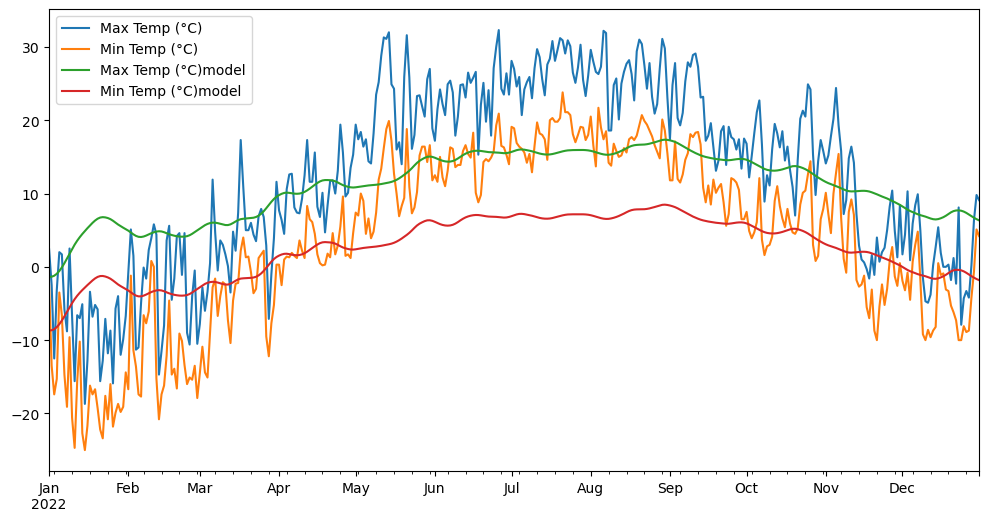

In [169]:
full_pred_test_df.drop(columns=cols_in).plot(figsize=(12,6))

In [ ]:
full_df.isna().sum()

In [ ]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]